This notebook narrates the <a href="https://www.kaggle.com/c/expedia-hotel-recommendations">Kaggle Expedia hotel recommendations competition </a>. I would like to acknowledge Vik Paruchuri for providing the wonderful guide for this competition.

The competition Details can be found at the above link. But I would like to summarize it for quick insight.

<b> The Expedia Kaggle competition</b>

The Expedia competition challenges you with predicting what hotel a user will book based on some attributes about the search the user is conducting on Expedia. Before we dive into any coding, we’ll need to put in time to understand both the problem and the data.

<b> Data Fields </b>

The details of the data fields is available at Kaggle site <a href="https://www.kaggle.com/c/expedia-hotel-recommendations/data"> data details </a>.


<b> Data Exploration </b>


In [69]:
#library imports
import pandas as pd
import numpy as np
import ml_metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
destinations = pd.read_csv("destinations.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv", parse_dates=['srch_ci', 'srch_co'])

In [4]:
#lets see the size of the different data files
print("train data size:",train.shape)
print("test data size:",test.shape)

train data size: (37670293, 24)
test data size: (2528243, 22)


We have about 37 million training set rows, and 2 million testing set rows, which will make this problem a bit challenging to work with.

We can explore the first few rows of the data:

In [5]:
train.head() #displays first 5 rows by default

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


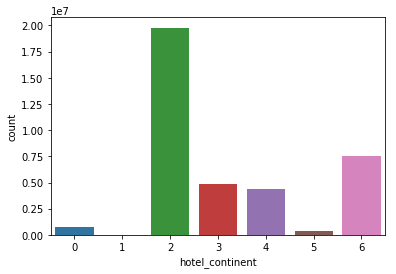

In [70]:
#lets do some data analysis and visualize the observaation
#lets observe the preferred hotel_continent
sns.countplot(x='hotel_continent', data=train)

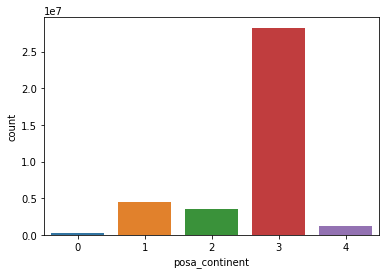

In [72]:
#lets see the preferred posa_continent
sns.countplot(x='posa_continent', data=train)

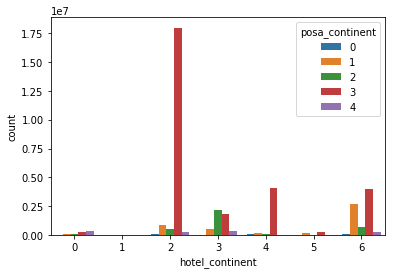

In [74]:
#lets have posa_continent and hotel_continent together
sns.countplot(x='hotel_continent', hue='posa_continent', data=train)

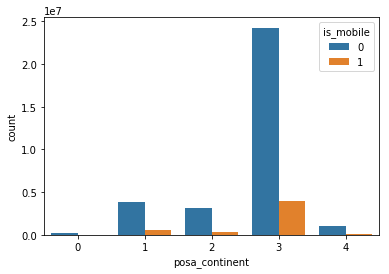

In [75]:
#lets observee the posa_continent and is_mobile together
sns.countplot(x='posa_continent', hue='is_mobile', data=train)

['2014-08-31' '2014-09-02' '2014-11-28' ..., '2558-03-16' '2557-11-15'
 '2025-09-13']


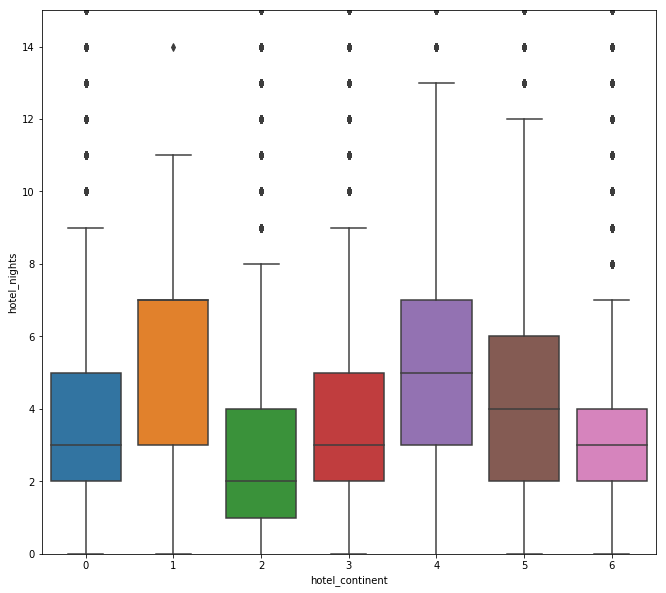

In [87]:
#lets observe the number of booked nights against the check ins and check outs
print(train['srch_co'].unique())
train_srch_co = pd.to_datetime(train['srch_co'], errors='coerce') #handle gracefully if any invalid datetime
train_srch_ci = pd.to_datetime(train['srch_ci'], errors='coerce') #handle gracefully if any invalid datetime
hotel_nights =  train_srch_co - train_srch_ci 
hotel_nights = (hotel_nights/np.timedelta64(1, 'D')).astype(float) #convert to float to avoid NA problem
train['hotel_nights'] = hotel_nights
plt.figure(figsize=(11, 10))
ax = sns.boxplot(x='hotel_continent', y='hotel_nights', data=train)
lim = ax.set(ylim=(0, 15))

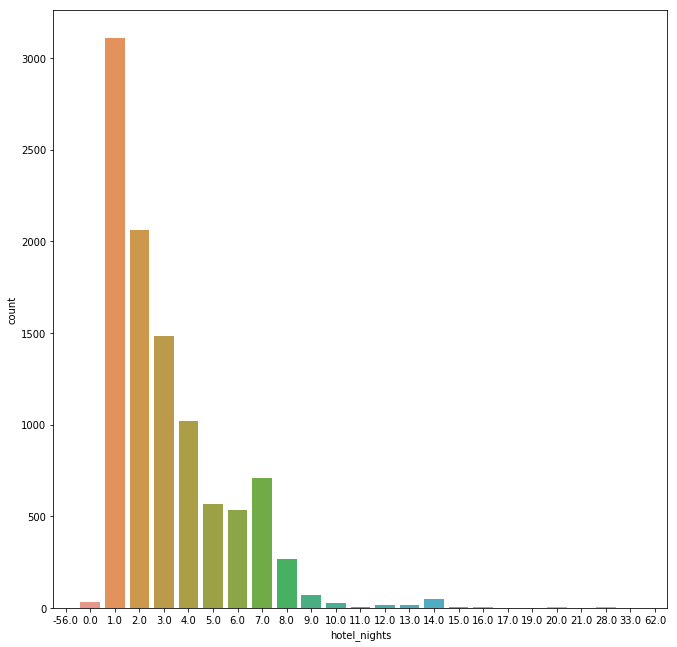

In [89]:
#lets see the distribution of hotel_nights
plt.figure(figsize=(11, 11))
sns.countplot(x="hotel_nights", data=train[:10000]) #will result in a very skewed plot because most reservations are for few days

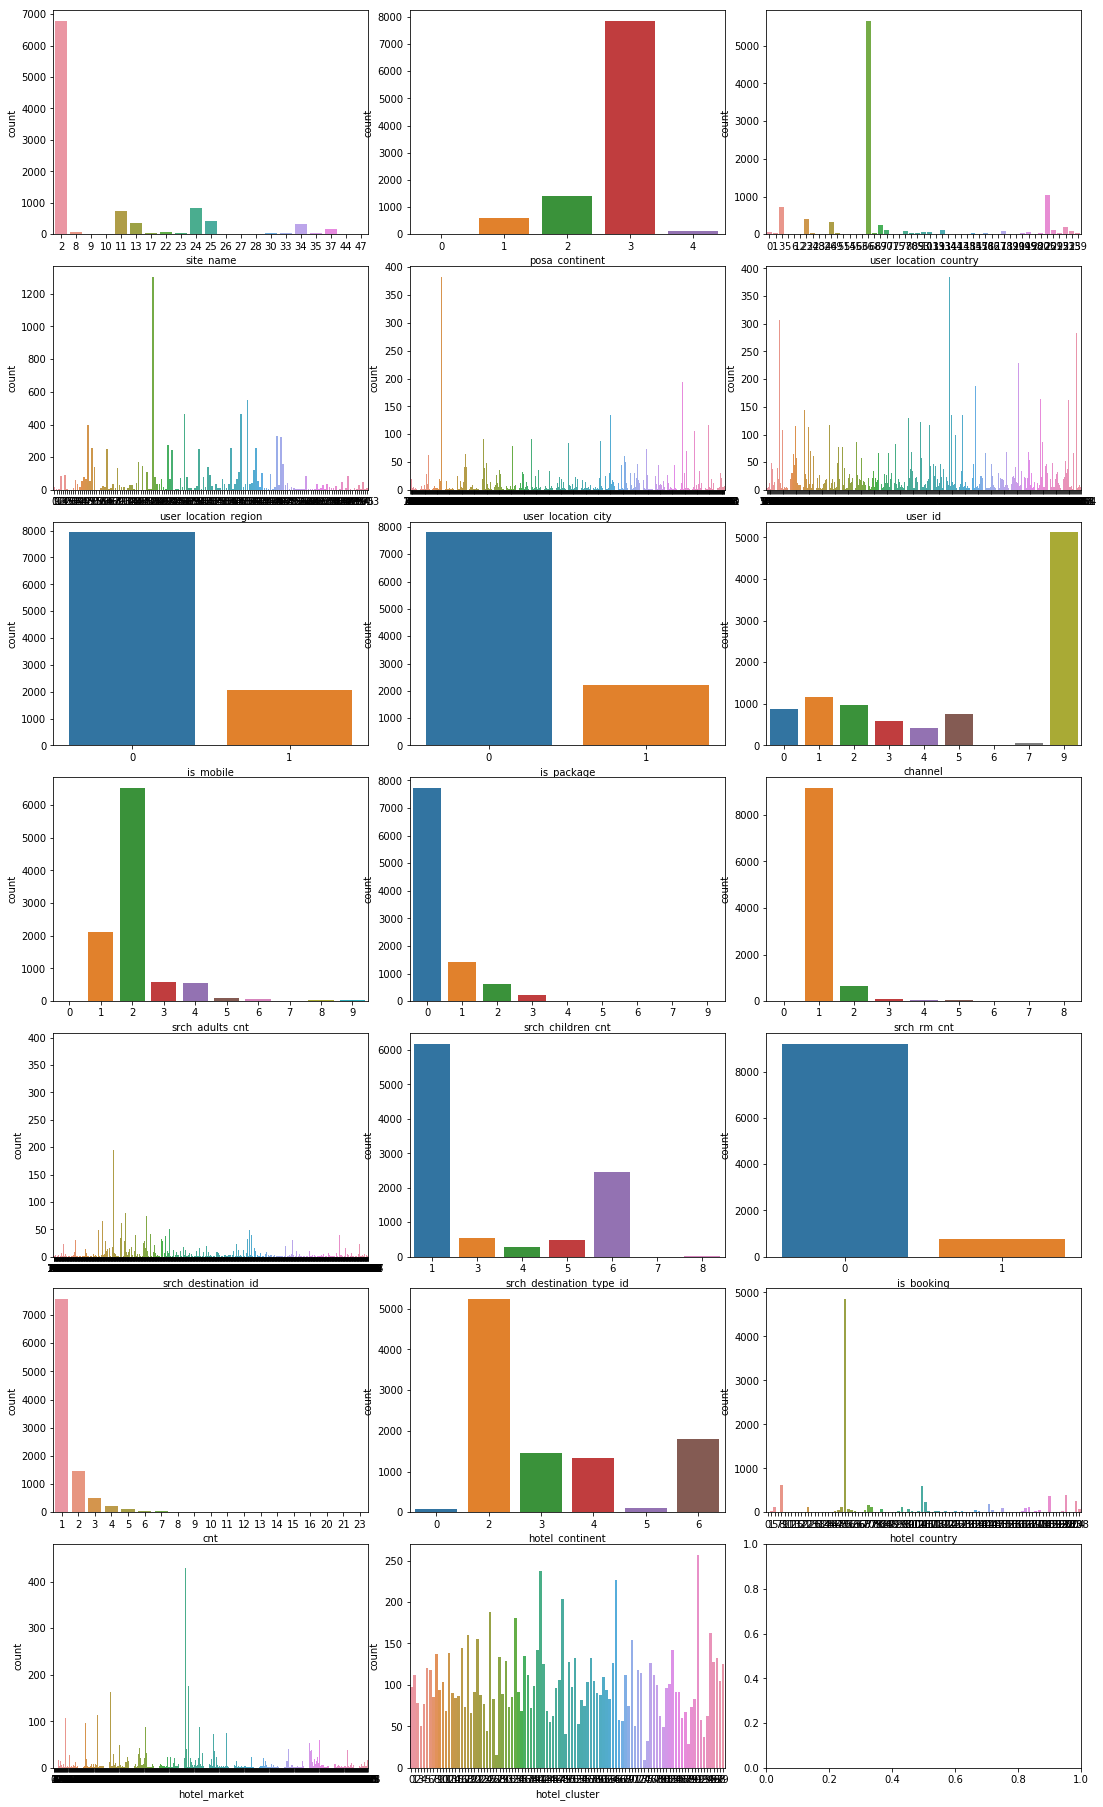

In [92]:
#lets see the count plot for all the features
plot_rows = train.columns.size//3 -1 #we will have three plots in a single row
fig, axes = plt.subplots(nrows = plot_rows, ncols = 3, figsize=(15, 25))
fig.tight_layout()
i = 0
j = 0
for col in train.columns:
    if j>=3:
        j = 0
        i+=1
    if train[col].dtype==np.int64:
        sns.countplot(x=col, data = train[:10000], ax=axes[i][j])
        j+=1

There are a few things that immediately stick out:

<ul>
<li> date_time could be useful in our predictions, so we’ll need to convert it.
<li> Most of the columns are integers or floats, so we can’t do a lot of feature engineering. For example, user_location_country isn’t the name of a country, it’s an integer. This makes it harder to create new features, because we don’t know exactly which each value means.
</ul>

In [6]:
test.head()

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,...,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,...,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538


There are a few things we can take away from looking at test.csv:

<ul>
<li> It looks like all the dates in test.csv are later than the dates in train.csv, and the <a href="https://www.kaggle.com/c/expedia-hotel-recommendations/data">data page</a> confirms this. The testing set contains dates from 2015, and the training set contains dates from 2013 and 2014.
<li> It looks like the user ids in test.csv are a subset of the user ids in train.csv, given the overlapping integer ranges. We can confirm this later on.
<li> The is_booking column always looks to be 1 in test.csv. The <a href="https://www.kaggle.com/c/expedia-hotel-recommendations/data">data page</a> confirms this.
</ul>


<b> What to predict </b>


We’ll be predicting which hotel_cluster a user will book after a given search. According to the description, there are 100 clusters in total.


<b> How we’ll be scored </b>

The evaluation page says that we’ll be scored using Mean Average Precision @ 5, which means that we’ll need to make 5 cluster predictions for each row, and will be scored on whether or not the correct prediction appears in our list. If the correct prediction comes earlier in the list, we get more points.

For example, if the “correct” cluster is 3, and we predict 4, 43, 60, 3, 20, our score will be lower than if we predict 3, 4, 43, 60, 20. We should put predictions we’re more certain about earlier in our list of predictions.


<b> Exploring Hotel Clusters </b>


In [7]:
train["hotel_cluster"].value_counts()

91    1043720
41     772743
48     754033
64     704734
65     670960
5      620194
98     589178
59     570291
42     551605
21     550092
70     545572
18     545284
83     534132
46     534038
25     530591
62     518809
95     509266
28     507016
68     503797
82     503755
37     496061
50     489892
30     489287
9      488328
58     483253
97     479446
16     477868
72     457463
1      452694
99     444887
       ...   
19     282893
84     278264
66     273505
38     269246
87     260398
23     259233
12     259022
31     257587
67     255946
43     253578
7      252447
54     250745
92     244343
89     243560
45     241408
49     240124
3      225250
80     220218
60     217919
71     216054
93     214293
86     209054
14     192299
75     165226
24     164127
35     139122
53     134812
88     107784
27     105040
74      48355
Name: hotel_cluster, Length: 100, dtype: int64

The output above is truncated, but it shows that the number of hotels in each cluster is fairly evenly distributed. There doesn’t appear to be any relationship between cluster number and the number of items.

<b>Exploring train and test user ids</b>


Finally, we’ll confirm our hypothesis that all the test user ids are found in the train DataFrame. We can do this by finding the unique values for user_id in test, and seeing if they all exist in train.

In [8]:
#find the intersection of train and test user ids
test_ids = set(test["user_id"].unique())
train_ids = set(train.user_id.unique())
intersection_count = len(test_ids & train_ids)
intersection_count == len(test_ids)

True

In [9]:
#another way to do this using numpy array
a = np.array(list(test_ids)) # donot know why in jupyter I need to cast the set to list before converting to array, in python console a set can be directly converted to array
b = np.array(list(train_ids))
common_users = np.intersect1d(a, b)
print(len(common_users), len(test_ids))
len(common_users) == len(test_ids)

1181577 1181577


True

Looks like our hypothesis is correct, which will make working with this data much easier!

<b> Downsampling our Kaggle data </b>


The entire train.csv dataset contains 37 million rows, which makes it hard to experiment with different techniques. Ideally, we want a small enough dataset that lets us quickly iterate through different approaches but is still representative of the whole training data.

We can do this by first randomly sampling rows from our data, then selecting new training and testing datasets from train.csv. By selecting both sets from train.csv, we’ll have the true hotel_cluster label for every row, and we’ll be able to calculate our accuracy as we test techniques

<b> Add in times and dates</b>

The first step is to add month and year fields to train. Because the train and test data is differentiated by date, we’ll need to add date fields to allow us to segment our data into two sets the same way. If we add year and month fields, we can split our data into training and testing sets using them.

The code below will:
<ul>
<li> Convert the date_time column in train from an object to a datetime value. This makes it easier to work with as a date.
<li> Extract the year and month from from date_time, and assign them to their own columns.
</ul>

In [10]:
train["date_time"] = pd.to_datetime(train["date_time"])
train["year"] = train["date_time"].dt.year
train["month"] = train["date_time"].dt.month

<b> Pick 10000 users</b>

Because the user ids in test are a subset of the user ids in train, we’ll need to do our random sampling in a way that preserves the full data of each user. We can accomplish this by selecting a certain number of users randomly, then only picking rows from train where user_id is in our random sample of user ids.


In [11]:
import random

unique_user_ids = train["user_id"].unique()
sel_user_ids = random.sample(set(unique_user_ids),10000)
sel_train = train[train.user_id.isin(sel_user_ids)]

<b> Pick new training and testing sets </b>

We’ll now need to pick new training and testing sets from sel_train. We’ll call these sets t1 and t2.


In [12]:
t1 = sel_train[((sel_train.year == 2013) | ((sel_train.year == 2014) & (sel_train.month < 8)))]
t2 = sel_train[((sel_train.year == 2014) & (sel_train.month >= 8))]


In the original train and test DataFrames, test contained data from 2015, and train contained data from 2013 and 2014. We split this data so that anything after July 2014 is in t2, and anything before is in t1. This gives us smaller training and testing sets with similar characteristics to train and test.

<b> Remove click events</b>

If is_booking is 0, it represents a click, and a 1 represents a booking.  test contains only booking events, so we’ll need to sample t2 to only contain bookings as well.

In [13]:
t2 = t2[t2.is_booking == 1]

<b> A simple algorithm</b>


The most simple technique we could try on this data is to find the most common clusters across the data, then use them as predictions. (Whichever cluster has many user_ids will be assumed to be the WINNER!!!)

We can again use the value_counts method to help us here:

In [18]:
#lets take few of the top clusters
most_common_clusters = list(train.hotel_cluster.value_counts().head().index)
print(train.hotel_cluster.value_counts().head())
print(most_common_clusters)

91    1043720
41     772743
48     754033
64     704734
65     670960
Name: hotel_cluster, dtype: int64
[91, 41, 48, 64, 65]




The above code will give us a list of the 5 most common clusters in train. This is because the head method returns the first 5 rows by default, and the index property will return the index of the DataFrame, which is the hotel cluster after running the value_counts method.

<b>Generating predictions</b>


We can turn most_common_clusters into a list of predictions by making the same prediction for each row.



In [19]:
predictions = [most_common_clusters for i in range(t2.shape[0])]
#print(predictions[0])
#print(len(predictions), t2.shape)

This will create a list with as many elements as there are rows in t2. Each element will be equal to most_common_clusters.

<b> Evaluating error</b>


In order to evaluate error, we’ll first need to figure out how to compute Mean Average Precision. Luckily, <a href="https://github.com/benhamner">Ben Hamner</a> has written an implementation that can be found <a href="https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py">here</a>. It can be installed as part of the ml_metrics package, and you can find installation instructions for how to install it here.

We can compute our error metric with the mapk method in ml_metrics. 

In [29]:
target = [[l] for l in t2["hotel_cluster"]]
#metrics.mapk(target, predictions, k=5)
#the mapk takes list of lists as the target and predictions
print(metrics.mapk(target, predictions, k=5))

0.060291038526


Our target needs to be in list of lists format for mapk to work, so we convert the hotel_cluster column of t2 into a list of lists. Then, we call the mapk method with our target, our predictions, and the number of predictions we want to evaluate (5).

Our result here isn’t great, but we’ve just generated our first set of predictions, and evaluated our error! The framework we’ve built will allow us to quickly test out a variety of techniques and see how they score. We’re well on our way to building a good-performing solution for the leaderboard.

<b> Finding correlations </b>


Before we move on to creating a better algorithm, let’s see if anything correlates well with hotel_cluster. This will tell us if we should dive more into any particular columns.

We can find linear correlations in the training set using the corr method:

In [30]:
train.corr()["hotel_cluster"]

site_name                   -0.022408
posa_continent               0.014938
user_location_country       -0.010477
user_location_region         0.007453
user_location_city           0.000831
orig_destination_distance    0.007260
user_id                      0.001052
is_mobile                    0.008412
is_package                   0.038733
channel                      0.000707
srch_adults_cnt              0.012309
srch_children_cnt            0.016261
srch_rm_cnt                 -0.005954
srch_destination_id         -0.011712
srch_destination_type_id    -0.032850
is_booking                  -0.021548
cnt                          0.002944
hotel_continent             -0.013963
hotel_country               -0.024289
hotel_market                 0.034205
hotel_cluster                1.000000
year                        -0.001050
month                       -0.000560
Name: hotel_cluster, dtype: float64

This tells us that no columns correlate linearly with hotel_cluster. This makes sense, because there is no linear ordering to hotel_cluster. For example, having a higher cluster number isn’t tied to having a higher srch_destination_id.

Unfortunately, this means that techniques like linear regression and logistic regression won’t work well on our data, because they rely on linear correlations between predictors and targets.



<b> Creating better predictions for our Kaggle entry</b>

This data for this competition is quite difficult to make predictions on using machine learning for a few reasons:

<ul>

<li> There are millions of rows, which increases runtime and memory usage for algorithms.

<li> There are 100 different clusters, and according to the competition admins, the boundaries are fairly fuzzy, so it will likely be hard to make predictions. As the number of clusters increases, classifiers generally decrease in accuracy.

<li> Nothing is linearly correlated with the target (hotel_clusters), meaning we can’t use fast machine learning techniques like linear regression.


For these reasons, machine learning probably won’t work well on our data, but we can try an algorithm and find out.

<b> Generating features</b>

The first step in applying machine learning is to generate features. We can generate features using both what’s available in the training data, and what’s available in destinations. We haven’t looked at destinations yet, so let’s take a quick peek.

<b> Generating features from destinations</b>

Destinations contains an id that corresponds to srch_destination_id, along with 149 columns of latent information about that destination. Here’s a sample:

In [31]:
destinations.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


The competition doesn’t tell us exactly what each latent feature is, but it’s safe to assume that it’s some combination of destination characteristics, like name, description, and more. These latent features were converted to numbers, so they could be anonymized.

We can use the destination information as features in a machine learning algorithm, but we’ll need to compress the number of columns down first, to minimize runtime. We can use PCA to do this. PCA will reduce the number of columns in a matrix while trying to preserve the same amount of variance per row. Ideally, PCA will compress all the information contained in all the columns into less, but in practice, some information is lost.

In the code below, we:

<ul>
<li> Initialize a PCA model using scikit-learn.
<li> Specify that we want to only have 3 columns in our data.
<li> Transform the columns d1-d149 into 3 columns.

</ul>

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
# we skip the srch_destination_id from dimensionality reduction because we might need to extract it later
dest_small = pca.fit_transform(destinations[["d{0}".format(i + 1) for i in range(149)]])
dest_small = pd.DataFrame(dest_small)
#now we apply the srch_destination_id to our dimension reduced data
dest_small["srch_destination_id"] = destinations["srch_destination_id"]
#lets see the column names
print(dest_small.columns.values)
print(dest_small.head())

[0 1 2 'srch_destination_id']
          0         1         2  srch_destination_id
0 -0.044268  0.169419  0.032518                    0
1 -0.440761  0.077405 -0.091572                    1
2  0.001033  0.020677  0.012110                    2
3 -0.480467 -0.040345 -0.019320                    3
4 -0.207253 -0.042694 -0.011745                    4


The above code compresses the 149 columns in destinations down to 3 columns, and creates a new DataFrame called dest_small. We preserve most of the variance in destinations while doing this, so we don’t lose a lot of information, but save a lot of runtime for a machine learning algorithm.

<b>Generating features</b>

Now that the preliminaries are done with, we can generate our features. We’ll do the following:

<ul>

<li> Generate new date features based on date_time, srch_ci, and srch_co.
<li> Remove non-numeric columns like date_time.
<li> Add in features from dest_small.
<li> Replace any missing values with -1.
</ul

In [34]:
#lets review the columns in train and test set
print(train.columns.values)
print(test.columns.values)

['date_time' 'site_name' 'posa_continent' 'user_location_country'
 'user_location_region' 'user_location_city' 'orig_destination_distance'
 'user_id' 'is_mobile' 'is_package' 'channel' 'srch_ci' 'srch_co'
 'srch_adults_cnt' 'srch_children_cnt' 'srch_rm_cnt' 'srch_destination_id'
 'srch_destination_type_id' 'is_booking' 'cnt' 'hotel_continent'
 'hotel_country' 'hotel_market' 'hotel_cluster' 'year' 'month']
['id' 'date_time' 'site_name' 'posa_continent' 'user_location_country'
 'user_location_region' 'user_location_city' 'orig_destination_distance'
 'user_id' 'is_mobile' 'is_package' 'channel' 'srch_ci' 'srch_co'
 'srch_adults_cnt' 'srch_children_cnt' 'srch_rm_cnt' 'srch_destination_id'
 'srch_destination_type_id' 'hotel_continent' 'hotel_country'
 'hotel_market']


In [36]:
def calc_fast_features(df):
    df["date_time"] = pd.to_datetime(df["date_time"])
    df["srch_ci"] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df["srch_co"] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    
    props = {}
    for prop in ["month", "day", "hour", "minute", "dayofweek", "quarter"]:
        props[prop] = getattr(df["date_time"].dt, prop)
    
    carryover = [p for p in df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
    for prop in carryover:
        props[prop] = df[prop]
    
    date_props = ["month", "day", "dayofweek", "quarter"]
    for prop in date_props:
        props["ci_{0}".format(prop)] = getattr(df["srch_ci"].dt, prop)
        props["co_{0}".format(prop)] = getattr(df["srch_co"].dt, prop)
    props["stay_span"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')
        
    ret = pd.DataFrame(props)
    
    ret = ret.join(dest_small, on="srch_destination_id", how='left', rsuffix="dest")
    ret = ret.drop("srch_destination_iddest", axis=1)
    return ret

df = calc_fast_features(t1)
df.fillna(-1, inplace=True)
print(df.columns.values)
print(df.head())

C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

['channel' 'ci_day' 'ci_dayofweek' 'ci_month' 'ci_quarter' 'cnt' 'co_day'
 'co_dayofweek' 'co_month' 'co_quarter' 'day' 'dayofweek' 'hotel_cluster'
 'hotel_continent' 'hotel_country' 'hotel_market' 'hour' 'is_booking'
 'is_mobile' 'is_package' 'minute' 'month' 'orig_destination_distance'
 'posa_continent' 'quarter' 'site_name' 'srch_adults_cnt'
 'srch_children_cnt' 'srch_destination_id' 'srch_destination_type_id'
 'srch_rm_cnt' 'stay_span' 'user_id' 'user_location_city'
 'user_location_country' 'user_location_region' 'year' 0 1 2]
      channel  ci_day  ci_dayofweek  ci_month  ci_quarter  cnt  co_day  \
1349        9    19.0           1.0      11.0         4.0    7    24.0   
1350        9    20.0           2.0      11.0         4.0    1    25.0   
1351        2    16.0           6.0      11.0         4.0    1    19.0   
1352        2    16.0           6.0      11.0         4.0    1    20.0   
1353        2    16.0           6.0      11.0         4.0    1    16.0   

      co_dayofweek

The above will calculate features such as length of stay, check in day, and check out month. These features will help us train a machine learning algorithm later on.

Replacing missing values with -1 isn’t the best choice, but it will work fine for now, and we can always optimize the behavior later on.


<b> Machine learning</b>

Now that we have features for our training data, we can try machine learning. We’ll use 3-fold cross validation across the training set to generate a reliable error estimate. Cross validation splits the training set up into 3 parts, then predicts hotel_cluster for each part using the other parts to train with.

We’ll generate predictions using the Random Forest algorithm. Random forests build trees, which can fit to nonlinear tendencies in data. This will enable us to make predictions, even though none of our columns are linearly related.

We’ll first initialize the model and compute cross validation scores:


In [39]:
predictors = [c for c in df.columns if c not in ["hotel_cluster"]]
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
scores = cross_validation.cross_val_score(clf, df[predictors], df['hotel_cluster'], cv=3)
scores

array([ 0.06832355,  0.06395536,  0.07012055])

The above code doesn’t give us very good accuracy, and confirms our original suspicion that machine learning isn’t a great approach to this problem. However, classifiers tend to have lower accuracy when there is a high cluster count. We can instead try training 100 binary classifiers. Each classifier will just determine if a row is in it’s cluster, or not. This will entail training one classifier per label in hotel_cluster.

<b> Binary classifiers</b>

We’ll again train Random Forests, but each forest will predict only a single hotel cluster. We’ll use 2 fold cross validation for speed, and only train 10 trees per label.

In the code below, we:

<ul>

<li> Loop across each unique hotel_cluster.
<ul>
    <li> Train a Random Forest classifier using 2-fold cross validation.
    <li> Extract the probabilities from the classifier that the row is in the unique hotel_cluster
</ul>
<li> Combine all the probabilities.
<li> For each row, find the 5 largest probabilities, and assign those hotel_cluster values as predictions.
<li> Compute accuracy using mapk.
</ul>

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from itertools import chain

all_probs = []
unique_clusters = df["hotel_cluster"].unique()
for cluster in unique_clusters:
    df["target"] = 1
    df["target"][df["hotel_cluster"] != cluster] = 0
    predictors = [col for col in df if col not in ['hotel_cluster', "target"]]
    probs = []
    cv = KFold(len(df["target"]), n_folds=2)
    clf = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
    for i, (tr, te) in enumerate(cv):
        #print(tr)
        #print(te)
        #print(df[predictors].iloc[tr])
        clf.fit(df[predictors].iloc[tr], df["target"].iloc[tr])
        preds = clf.predict_proba(df[predictors].iloc[te])
        probs.append([p[1] for p in preds])
    full_probs = chain.from_iterable(probs)
    all_probs.append(list(full_probs))

prediction_frame = pd.DataFrame(all_probs).T
prediction_frame.columns = unique_clusters
def find_top_5(row):
    return list(row.nlargest(5).index)

preds = []
for index, row in prediction_frame.iterrows():
    preds.append(find_top_5(row))

#print(t2.columns.values)
#print(t1.columns.values)
metrics.mapk([[l] for l in t2["hotel_cluster"]], preds, k=5)

C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\rbara012.AD.001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

0.046771356783919589

This performed even worse than before. So, we need to think of something else to get better performance.

<b> Top clusters based on hotel_cluster</b> 

There are a few <a href="https://www.kaggle.com/c/expedia-hotel-recommendations/scripts">Kaggle Scripts</a> for the competition that involve aggregating hotel_cluster based on orig_destination_distance, or srch_destination_id. Aggregating on orig_destination_distance will exploit a data leak in the competition, and attempt to match the same user together. Aggregating on srch_destination_id will find the most popular hotel clusters for each destination. We’ll then be able to predict that a user who searches for a destination is going to one of the most popular hotel clusters for that destination. Think of this as a more granular version of the most common clusters technique we used earlier.

We can first generate scores for each hotel_cluster in each srch_destination_id. We’ll weight bookings higher than clicks. This is because the test data is all booking data, and this is what we want to predict. We want to include click information, but downweight it to reflect this. Step by step, we’ll:

<ul>
<li> Group t1 by srch_destination_id, and hotel_cluster.
<li> Iterate through each group, and:
    <ul>
    <li> Assign 1 point to each hotel cluster where is_booking is True.
    <li> Assign .15 points to each hotel cluster where is_booking is False.
    <li> Assign the score to the srch_destination_id / hotel_cluster combination in a dictionary.
    </ul>

</ul>

Here’s the code to accomplish the above steps:

In [42]:
def make_key(items):
    #print("making key for",str(items))
    return "_".join([str(i) for i in items])

match_cols = ["srch_destination_id"]
cluster_cols = match_cols + ['hotel_cluster']

groups = t1.groupby(cluster_cols)
top_clusters = {}
for name, group in groups:
    clicks = len(group.is_booking[group.is_booking == False])
    bookings = len(group.is_booking[group.is_booking == True])
    
    score = bookings + .15 * clicks
    
    clus_name = make_key(name[:len(match_cols)])
    if clus_name not in top_clusters:
        top_clusters[clus_name] = {}
    top_clusters[clus_name][name[-1]] = score

At the end, we’ll have a dictionary where each key is an srch_destination_id. Each value in the dictionary will be another dictionary, containing hotel clusters as keys with scores as values. Here’s how it looks:

In [43]:
for clus_name in top_clusters:
    clus_dict = top_clusters[clus_name]
    print("\nfor srch_destination_id ",str(clus_name))
    for item in clus_dict:
        print("hotel cluster:",item, " cluster score:", clus_dict[item])


for srch_destination_id  26980
hotel cluster: 51  cluster score: 0.44999999999999996
hotel cluster: 34  cluster score: 0.15
hotel cluster: 69  cluster score: 0.3
hotel cluster: 72  cluster score: 2.9
hotel cluster: 42  cluster score: 0.3
hotel cluster: 76  cluster score: 0.3
hotel cluster: 2  cluster score: 2.2
hotel cluster: 46  cluster score: 0.3
hotel cluster: 16  cluster score: 0.15
hotel cluster: 49  cluster score: 0.44999999999999996
hotel cluster: 18  cluster score: 1.3
hotel cluster: 19  cluster score: 0.15
hotel cluster: 21  cluster score: 1.9
hotel cluster: 25  cluster score: 4.95
hotel cluster: 59  cluster score: 0.8999999999999999
hotel cluster: 28  cluster score: 0.15
hotel cluster: 95  cluster score: 1.3

for srch_destination_id  667
hotel cluster: 62  cluster score: 0.15

for srch_destination_id  51782
hotel cluster: 25  cluster score: 0.15
hotel cluster: 5  cluster score: 0.15
hotel cluster: 61  cluster score: 0.15

for srch_destination_id  33737
hotel cluster: 61  clu

hotel cluster: 39  cluster score: 1.3
hotel cluster: 72  cluster score: 1.45
hotel cluster: 73  cluster score: 1.5
hotel cluster: 42  cluster score: 0.15
hotel cluster: 71  cluster score: 0.6
hotel cluster: 44  cluster score: 0.3
hotel cluster: 78  cluster score: 0.15
hotel cluster: 17  cluster score: 0.15
hotel cluster: 50  cluster score: 0.3
hotel cluster: 51  cluster score: 0.3
hotel cluster: 20  cluster score: 0.15
hotel cluster: 25  cluster score: 0.44999999999999996
hotel cluster: 26  cluster score: 0.15
hotel cluster: 28  cluster score: 0.8999999999999999
hotel cluster: 90  cluster score: 3.15
hotel cluster: 30  cluster score: 0.44999999999999996
hotel cluster: 31  cluster score: 1.5

for srch_destination_id  11486
hotel cluster: 53  cluster score: 0.15

for srch_destination_id  13852
hotel cluster: 32  cluster score: 0.15
hotel cluster: 48  cluster score: 0.3
hotel cluster: 50  cluster score: 0.3
hotel cluster: 51  cluster score: 0.15
hotel cluster: 68  cluster score: 0.15
hote

hotel cluster: 47  cluster score: 2.6

for srch_destination_id  5712
hotel cluster: 40  cluster score: 0.15
hotel cluster: 42  cluster score: 0.15

for srch_destination_id  263
hotel cluster: 3  cluster score: 2.45
hotel cluster: 7  cluster score: 1.15
hotel cluster: 72  cluster score: 2.3
hotel cluster: 91  cluster score: 0.3
hotel cluster: 42  cluster score: 0.15
hotel cluster: 39  cluster score: 0.15
hotel cluster: 18  cluster score: 0.3
hotel cluster: 77  cluster score: 0.15
hotel cluster: 13  cluster score: 0.15
hotel cluster: 50  cluster score: 0.15
hotel cluster: 47  cluster score: 1.15
hotel cluster: 28  cluster score: 1.15

for srch_destination_id  10016
hotel cluster: 82  cluster score: 0.3
hotel cluster: 5  cluster score: 0.15
hotel cluster: 30  cluster score: 1.15
hotel cluster: 75  cluster score: 0.15
hotel cluster: 61  cluster score: 0.15
hotel cluster: 62  cluster score: 0.15

for srch_destination_id  7638
hotel cluster: 94  cluster score: 0.15

for srch_destination_id  

hotel cluster: 49  cluster score: 8.05
hotel cluster: 50  cluster score: 6.3
hotel cluster: 51  cluster score: 1.65
hotel cluster: 55  cluster score: 4.8
hotel cluster: 56  cluster score: 0.44999999999999996
hotel cluster: 59  cluster score: 6.25
hotel cluster: 60  cluster score: 0.15
hotel cluster: 64  cluster score: 0.6
hotel cluster: 68  cluster score: 1.75
hotel cluster: 69  cluster score: 10.2
hotel cluster: 70  cluster score: 11.8
hotel cluster: 72  cluster score: 9.7
hotel cluster: 73  cluster score: 2.6
hotel cluster: 76  cluster score: 0.6
hotel cluster: 77  cluster score: 6.6
hotel cluster: 83  cluster score: 3.0
hotel cluster: 86  cluster score: 1.65
hotel cluster: 87  cluster score: 1.15
hotel cluster: 90  cluster score: 0.3
hotel cluster: 91  cluster score: 6.1
hotel cluster: 93  cluster score: 0.3
hotel cluster: 94  cluster score: 2.65
hotel cluster: 95  cluster score: 6.35
hotel cluster: 96  cluster score: 0.8999999999999999
hotel cluster: 97  cluster score: 10.149999999

hotel cluster: 59  cluster score: 0.15
hotel cluster: 29  cluster score: 0.15

for srch_destination_id  27717
hotel cluster: 91  cluster score: 0.15

for srch_destination_id  6376
hotel cluster: 86  cluster score: 1.15

for srch_destination_id  3059
hotel cluster: 3  cluster score: 0.15
hotel cluster: 5  cluster score: 1.75
hotel cluster: 38  cluster score: 0.75
hotel cluster: 8  cluster score: 0.15
hotel cluster: 41  cluster score: 2.3499999999999996
hotel cluster: 11  cluster score: 0.75
hotel cluster: 44  cluster score: 1.2
hotel cluster: 78  cluster score: 0.3
hotel cluster: 99  cluster score: 0.15
hotel cluster: 81  cluster score: 0.3
hotel cluster: 82  cluster score: 0.75
hotel cluster: 67  cluster score: 0.3
hotel cluster: 62  cluster score: 0.15
hotel cluster: 22  cluster score: 3.3499999999999996
hotel cluster: 89  cluster score: 0.3
hotel cluster: 25  cluster score: 0.15
hotel cluster: 90  cluster score: 0.3
hotel cluster: 61  cluster score: 0.3
hotel cluster: 30  cluster sco

hotel cluster: 61  cluster score: 0.44999999999999996
hotel cluster: 62  cluster score: 1.05

for srch_destination_id  21492
hotel cluster: 89  cluster score: 0.15
hotel cluster: 27  cluster score: 0.15

for srch_destination_id  14148
hotel cluster: 18  cluster score: 0.44999999999999996
hotel cluster: 55  cluster score: 0.15
hotel cluster: 72  cluster score: 0.44999999999999996
hotel cluster: 90  cluster score: 0.3
hotel cluster: 91  cluster score: 1.05
hotel cluster: 28  cluster score: 0.6
hotel cluster: 98  cluster score: 0.6

for srch_destination_id  12132
hotel cluster: 2  cluster score: 0.15
hotel cluster: 4  cluster score: 0.6
hotel cluster: 5  cluster score: 0.3
hotel cluster: 6  cluster score: 1.15
hotel cluster: 10  cluster score: 1.45
hotel cluster: 13  cluster score: 0.6
hotel cluster: 15  cluster score: 1.15
hotel cluster: 16  cluster score: 0.15
hotel cluster: 18  cluster score: 0.75
hotel cluster: 19  cluster score: 0.15
hotel cluster: 20  cluster score: 0.15
hotel clust

hotel cluster: 21  cluster score: 3.45
hotel cluster: 23  cluster score: 0.15
hotel cluster: 25  cluster score: 2.9
hotel cluster: 90  cluster score: 2.6
hotel cluster: 91  cluster score: 1.75
hotel cluster: 28  cluster score: 1.05
hotel cluster: 94  cluster score: 0.15
hotel cluster: 32  cluster score: 4.9
hotel cluster: 33  cluster score: 2.6
hotel cluster: 39  cluster score: 0.3
hotel cluster: 40  cluster score: 1.0
hotel cluster: 41  cluster score: 0.75
hotel cluster: 42  cluster score: 2.75
hotel cluster: 47  cluster score: 2.75
hotel cluster: 48  cluster score: 0.44999999999999996
hotel cluster: 50  cluster score: 1.75
hotel cluster: 51  cluster score: 0.15
hotel cluster: 59  cluster score: 0.6
hotel cluster: 60  cluster score: 0.15

for srch_destination_id  17457
hotel cluster: 48  cluster score: 1.15
hotel cluster: 83  cluster score: 0.3
hotel cluster: 6  cluster score: 0.3
hotel cluster: 39  cluster score: 0.15
hotel cluster: 40  cluster score: 0.6
hotel cluster: 7  cluster sc

hotel cluster: 20  cluster score: 0.15
hotel cluster: 93  cluster score: 0.15

for srch_destination_id  10105
hotel cluster: 29  cluster score: 1.15

for srch_destination_id  6644
hotel cluster: 16  cluster score: 0.15
hotel cluster: 94  cluster score: 2.9

for srch_destination_id  24290
hotel cluster: 41  cluster score: 0.15
hotel cluster: 90  cluster score: 0.15
hotel cluster: 15  cluster score: 1.3

for srch_destination_id  16240
hotel cluster: 89  cluster score: 0.15
hotel cluster: 20  cluster score: 0.15
hotel cluster: 61  cluster score: 0.15

for srch_destination_id  20953
hotel cluster: 48  cluster score: 0.15
hotel cluster: 33  cluster score: 1.15
hotel cluster: 2  cluster score: 0.15
hotel cluster: 50  cluster score: 1.15
hotel cluster: 5  cluster score: 0.15
hotel cluster: 59  cluster score: 0.15
hotel cluster: 81  cluster score: 0.15
hotel cluster: 46  cluster score: 0.6
hotel cluster: 29  cluster score: 0.15
hotel cluster: 30  cluster score: 0.3

for srch_destination_id  56

hotel cluster: 58  cluster score: 1.3499999999999999
hotel cluster: 61  cluster score: 1.45
hotel cluster: 62  cluster score: 3.3499999999999996
hotel cluster: 63  cluster score: 1.3499999999999999

for srch_destination_id  29290
hotel cluster: 69  cluster score: 0.15
hotel cluster: 93  cluster score: 0.15

for srch_destination_id  18491
hotel cluster: 35  cluster score: 0.3
hotel cluster: 85  cluster score: 0.15
hotel cluster: 22  cluster score: 0.44999999999999996
hotel cluster: 8  cluster score: 0.75
hotel cluster: 9  cluster score: 0.3
hotel cluster: 90  cluster score: 0.15
hotel cluster: 43  cluster score: 1.15

for srch_destination_id  56777
hotel cluster: 82  cluster score: 1.15

for srch_destination_id  27173
hotel cluster: 40  cluster score: 0.15
hotel cluster: 48  cluster score: 1.75
hotel cluster: 42  cluster score: 1.75
hotel cluster: 28  cluster score: 0.6

for srch_destination_id  4767
hotel cluster: 33  cluster score: 0.15
hotel cluster: 91  cluster score: 0.6

for srch_

hotel cluster: 36  cluster score: 13.149999999999999
hotel cluster: 44  cluster score: 1.05
hotel cluster: 46  cluster score: 9.5
hotel cluster: 57  cluster score: 1.5
hotel cluster: 58  cluster score: 4.4
hotel cluster: 60  cluster score: 0.44999999999999996
hotel cluster: 61  cluster score: 2.3499999999999996
hotel cluster: 62  cluster score: 5.6

for srch_destination_id  22494
hotel cluster: 82  cluster score: 0.15
hotel cluster: 43  cluster score: 1.45

for srch_destination_id  18820
hotel cluster: 32  cluster score: 0.15
hotel cluster: 2  cluster score: 1.15
hotel cluster: 99  cluster score: 0.3
hotel cluster: 68  cluster score: 0.3
hotel cluster: 37  cluster score: 0.15
hotel cluster: 9  cluster score: 0.3
hotel cluster: 11  cluster score: 0.15
hotel cluster: 78  cluster score: 0.6
hotel cluster: 93  cluster score: 0.15
hotel cluster: 82  cluster score: 0.6
hotel cluster: 58  cluster score: 0.75
hotel cluster: 59  cluster score: 0.15
hotel cluster: 28  cluster score: 0.3
hotel cl

hotel cluster: 72  cluster score: 0.3
hotel cluster: 42  cluster score: 0.44999999999999996
hotel cluster: 13  cluster score: 0.3
hotel cluster: 77  cluster score: 0.15
hotel cluster: 16  cluster score: 1.75
hotel cluster: 91  cluster score: 1.2
hotel cluster: 28  cluster score: 0.15
hotel cluster: 94  cluster score: 1.3499999999999999

for srch_destination_id  56074
hotel cluster: 46  cluster score: 1.05

for srch_destination_id  59859
hotel cluster: 92  cluster score: 0.3
hotel cluster: 36  cluster score: 0.15

for srch_destination_id  12568
hotel cluster: 50  cluster score: 0.15
hotel cluster: 13  cluster score: 0.3

for srch_destination_id  55871
hotel cluster: 14  cluster score: 0.15

for srch_destination_id  11854
hotel cluster: 65  cluster score: 0.15
hotel cluster: 68  cluster score: 1.05
hotel cluster: 6  cluster score: 0.15
hotel cluster: 7  cluster score: 0.44999999999999996
hotel cluster: 72  cluster score: 0.6
hotel cluster: 73  cluster score: 1.7999999999999998
hotel clus

hotel cluster: 30  cluster score: 0.15
hotel cluster: 14  cluster score: 0.15

for srch_destination_id  19095
hotel cluster: 85  cluster score: 0.15
hotel cluster: 30  cluster score: 1.15

for srch_destination_id  49920
hotel cluster: 10  cluster score: 1.15
hotel cluster: 91  cluster score: 0.15
hotel cluster: 29  cluster score: 0.15

for srch_destination_id  68
hotel cluster: 81  cluster score: 1.3
hotel cluster: 20  cluster score: 0.15
hotel cluster: 53  cluster score: 0.15
hotel cluster: 38  cluster score: 5.699999999999999
hotel cluster: 97  cluster score: 0.15
hotel cluster: 57  cluster score: 0.44999999999999996
hotel cluster: 11  cluster score: 2.5
hotel cluster: 60  cluster score: 0.15
hotel cluster: 29  cluster score: 0.15
hotel cluster: 62  cluster score: 1.3
hotel cluster: 61  cluster score: 2.9

for srch_destination_id  6920
hotel cluster: 20  cluster score: 0.15

for srch_destination_id  5497
hotel cluster: 64  cluster score: 1.3499999999999999
hotel cluster: 67  cluster 

hotel cluster: 60  cluster score: 0.15
hotel cluster: 61  cluster score: 0.15
hotel cluster: 77  cluster score: 0.15

for srch_destination_id  27396
hotel cluster: 83  cluster score: 1.45
hotel cluster: 91  cluster score: 0.15
hotel cluster: 6  cluster score: 0.3
hotel cluster: 72  cluster score: 3.05
hotel cluster: 41  cluster score: 1.3
hotel cluster: 42  cluster score: 0.15
hotel cluster: 77  cluster score: 1.6
hotel cluster: 99  cluster score: 0.15
hotel cluster: 18  cluster score: 0.44999999999999996
hotel cluster: 19  cluster score: 0.15
hotel cluster: 9  cluster score: 0.3
hotel cluster: 90  cluster score: 0.15
hotel cluster: 59  cluster score: 0.3
hotel cluster: 93  cluster score: 0.15
hotel cluster: 95  cluster score: 1.15

for srch_destination_id  25417
hotel cluster: 16  cluster score: 0.3

for srch_destination_id  12890
hotel cluster: 8  cluster score: 0.6

for srch_destination_id  4170
hotel cluster: 91  cluster score: 1.15

for srch_destination_id  28676
hotel cluster: 19

hotel cluster: 21  cluster score: 0.3
hotel cluster: 95  cluster score: 0.3

for srch_destination_id  18481
hotel cluster: 3  cluster score: 0.15
hotel cluster: 68  cluster score: 0.3
hotel cluster: 5  cluster score: 0.6
hotel cluster: 7  cluster score: 0.15
hotel cluster: 76  cluster score: 0.3
hotel cluster: 11  cluster score: 0.3
hotel cluster: 12  cluster score: 0.15
hotel cluster: 15  cluster score: 0.6
hotel cluster: 82  cluster score: 0.15
hotel cluster: 83  cluster score: 0.15
hotel cluster: 85  cluster score: 0.3
hotel cluster: 25  cluster score: 0.44999999999999996
hotel cluster: 90  cluster score: 1.05
hotel cluster: 28  cluster score: 0.15
hotel cluster: 29  cluster score: 0.6
hotel cluster: 30  cluster score: 1.3
hotel cluster: 35  cluster score: 0.15
hotel cluster: 37  cluster score: 0.3
hotel cluster: 40  cluster score: 0.15
hotel cluster: 42  cluster score: 0.3
hotel cluster: 44  cluster score: 0.15
hotel cluster: 18  cluster score: 1.15
hotel cluster: 59  cluster score

hotel cluster: 91  cluster score: 0.15
hotel cluster: 59  cluster score: 0.3
hotel cluster: 28  cluster score: 0.15
hotel cluster: 13  cluster score: 1.3
hotel cluster: 94  cluster score: 0.3

for srch_destination_id  8034
hotel cluster: 90  cluster score: 0.15

for srch_destination_id  8226
hotel cluster: 97  cluster score: 0.3
hotel cluster: 11  cluster score: 1.6
hotel cluster: 36  cluster score: 0.3
hotel cluster: 38  cluster score: 1.3
hotel cluster: 43  cluster score: 1.15
hotel cluster: 44  cluster score: 0.3
hotel cluster: 46  cluster score: 7.15
hotel cluster: 61  cluster score: 0.44999999999999996
hotel cluster: 82  cluster score: 0.3
hotel cluster: 20  cluster score: 1.3
hotel cluster: 58  cluster score: 3.2
hotel cluster: 29  cluster score: 0.44999999999999996
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  43055
hotel cluster: 48  cluster score: 2.3
hotel cluster: 18  cluster score: 2.45
hotel cluster: 7  cluster score: 0.3
hotel cluster: 90  cluster score

hotel cluster: 13  cluster score: 0.15
hotel cluster: 77  cluster score: 0.15
hotel cluster: 47  cluster score: 0.15

for srch_destination_id  26813
hotel cluster: 48  cluster score: 0.15
hotel cluster: 91  cluster score: 0.15
hotel cluster: 43  cluster score: 0.15
hotel cluster: 94  cluster score: 1.3

for srch_destination_id  38878
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  25279
hotel cluster: 42  cluster score: 0.3
hotel cluster: 91  cluster score: 0.15

for srch_destination_id  12425
hotel cluster: 57  cluster score: 0.15
hotel cluster: 46  cluster score: 0.15
hotel cluster: 30  cluster score: 0.15
hotel cluster: 61  cluster score: 0.15

for srch_destination_id  21921
hotel cluster: 62  cluster score: 0.15

for srch_destination_id  11863
hotel cluster: 42  cluster score: 1.3
hotel cluster: 91  cluster score: 0.15
hotel cluster: 14  cluster score: 1.15

for srch_destination_id  28597
hotel cluster: 76  cluster score: 0.15

for srch_destination_id  13443
hotel 

hotel cluster: 75  cluster score: 0.15
hotel cluster: 82  cluster score: 0.3

for srch_destination_id  25
hotel cluster: 32  cluster score: 1.15
hotel cluster: 50  cluster score: 0.3
hotel cluster: 91  cluster score: 1.3
hotel cluster: 90  cluster score: 0.15
hotel cluster: 39  cluster score: 0.15

for srch_destination_id  51451
hotel cluster: 38  cluster score: 0.15

for srch_destination_id  11939
hotel cluster: 4  cluster score: 0.6
hotel cluster: 5  cluster score: 0.6
hotel cluster: 72  cluster score: 2.95
hotel cluster: 10  cluster score: 0.15
hotel cluster: 11  cluster score: 1.9
hotel cluster: 76  cluster score: 0.6
hotel cluster: 13  cluster score: 1.05
hotel cluster: 14  cluster score: 0.6
hotel cluster: 77  cluster score: 0.3
hotel cluster: 16  cluster score: 0.44999999999999996
hotel cluster: 18  cluster score: 2.5
hotel cluster: 83  cluster score: 1.3
hotel cluster: 20  cluster score: 0.15
hotel cluster: 23  cluster score: 0.44999999999999996
hotel cluster: 25  cluster score

hotel cluster: 82  cluster score: 0.15

for srch_destination_id  21834
hotel cluster: 62  cluster score: 0.15
hotel cluster: 30  cluster score: 0.3
hotel cluster: 93  cluster score: 0.3

for srch_destination_id  3475
hotel cluster: 50  cluster score: 0.15

for srch_destination_id  18869
hotel cluster: 78  cluster score: 0.15

for srch_destination_id  8804
hotel cluster: 83  cluster score: 0.15
hotel cluster: 3  cluster score: 0.15
hotel cluster: 68  cluster score: 0.15
hotel cluster: 5  cluster score: 0.15
hotel cluster: 9  cluster score: 0.15
hotel cluster: 42  cluster score: 0.15
hotel cluster: 11  cluster score: 0.15
hotel cluster: 12  cluster score: 0.15
hotel cluster: 77  cluster score: 0.15
hotel cluster: 48  cluster score: 0.44999999999999996
hotel cluster: 91  cluster score: 0.15
hotel cluster: 51  cluster score: 0.15
hotel cluster: 21  cluster score: 0.15
hotel cluster: 89  cluster score: 1.15
hotel cluster: 25  cluster score: 0.3
hotel cluster: 90  cluster score: 0.15
hotel c

hotel cluster: 61  cluster score: 1.3499999999999999
hotel cluster: 62  cluster score: 5.6499999999999995
hotel cluster: 63  cluster score: 0.8999999999999999

for srch_destination_id  5348
hotel cluster: 40  cluster score: 0.15
hotel cluster: 75  cluster score: 0.44999999999999996

for srch_destination_id  13820
hotel cluster: 33  cluster score: 0.3

for srch_destination_id  41835
hotel cluster: 48  cluster score: 1.3
hotel cluster: 83  cluster score: 0.15
hotel cluster: 28  cluster score: 0.3
hotel cluster: 94  cluster score: 0.44999999999999996

for srch_destination_id  12465
hotel cluster: 48  cluster score: 0.15
hotel cluster: 18  cluster score: 1.15
hotel cluster: 30  cluster score: 1.15
hotel cluster: 7  cluster score: 1.15

for srch_destination_id  13378
hotel cluster: 51  cluster score: 1.15
hotel cluster: 21  cluster score: 0.15
hotel cluster: 73  cluster score: 0.15
hotel cluster: 72  cluster score: 3.75
hotel cluster: 25  cluster score: 0.15
hotel cluster: 91  cluster score

hotel cluster: 94  cluster score: 1.3
hotel cluster: 72  cluster score: 1.3

for srch_destination_id  3361
hotel cluster: 16  cluster score: 1.6
hotel cluster: 32  cluster score: 0.44999999999999996
hotel cluster: 50  cluster score: 1.75
hotel cluster: 33  cluster score: 0.44999999999999996

for srch_destination_id  34847
hotel cluster: 15  cluster score: 1.3

for srch_destination_id  3483
hotel cluster: 91  cluster score: 2.45

for srch_destination_id  13652
hotel cluster: 16  cluster score: 0.3
hotel cluster: 32  cluster score: 0.15
hotel cluster: 19  cluster score: 0.15
hotel cluster: 39  cluster score: 0.15
hotel cluster: 57  cluster score: 0.15
hotel cluster: 47  cluster score: 0.3

for srch_destination_id  1909
hotel cluster: 82  cluster score: 0.75
hotel cluster: 36  cluster score: 1.3
hotel cluster: 46  cluster score: 0.75
hotel cluster: 30  cluster score: 0.3
hotel cluster: 11  cluster score: 0.6
hotel cluster: 62  cluster score: 1.45
hotel cluster: 85  cluster score: 0.3

for

hotel cluster: 94  cluster score: 0.15
hotel cluster: 69  cluster score: 0.15
hotel cluster: 37  cluster score: 1.6

for srch_destination_id  31009
hotel cluster: 49  cluster score: 0.3
hotel cluster: 7  cluster score: 1.45

for srch_destination_id  47097
hotel cluster: 81  cluster score: 0.15

for srch_destination_id  55150
hotel cluster: 90  cluster score: 0.15
hotel cluster: 46  cluster score: 0.15

for srch_destination_id  13307
hotel cluster: 64  cluster score: 0.15
hotel cluster: 25  cluster score: 0.15
hotel cluster: 99  cluster score: 0.15
hotel cluster: 22  cluster score: 1.15

for srch_destination_id  46103
hotel cluster: 30  cluster score: 1.15

for srch_destination_id  12198
hotel cluster: 16  cluster score: 0.15
hotel cluster: 48  cluster score: 0.15
hotel cluster: 83  cluster score: 0.15
hotel cluster: 13  cluster score: 0.15

for srch_destination_id  11500
hotel cluster: 67  cluster score: 2.5
hotel cluster: 20  cluster score: 0.3
hotel cluster: 53  cluster score: 1.45



hotel cluster: 14  cluster score: 0.15

for srch_destination_id  26482
hotel cluster: 14  cluster score: 0.3

for srch_destination_id  12502
hotel cluster: 32  cluster score: 1.15
hotel cluster: 42  cluster score: 0.15
hotel cluster: 91  cluster score: 0.15
hotel cluster: 82  cluster score: 0.15
hotel cluster: 6  cluster score: 0.15

for srch_destination_id  2626
hotel cluster: 44  cluster score: 0.15
hotel cluster: 5  cluster score: 0.15

for srch_destination_id  25964
hotel cluster: 17  cluster score: 0.15
hotel cluster: 91  cluster score: 0.15
hotel cluster: 51  cluster score: 1.15
hotel cluster: 33  cluster score: 0.44999999999999996
hotel cluster: 39  cluster score: 1.45
hotel cluster: 55  cluster score: 1.3
hotel cluster: 47  cluster score: 0.15

for srch_destination_id  4531
hotel cluster: 91  cluster score: 0.15
hotel cluster: 94  cluster score: 0.15
hotel cluster: 15  cluster score: 0.15

for srch_destination_id  13924
hotel cluster: 5  cluster score: 0.15
hotel cluster: 47  c

hotel cluster: 94  cluster score: 0.3
hotel cluster: 95  cluster score: 1.6

for srch_destination_id  42237
hotel cluster: 77  cluster score: 0.15

for srch_destination_id  20127
hotel cluster: 15  cluster score: 1.15

for srch_destination_id  28315
hotel cluster: 57  cluster score: 0.15
hotel cluster: 14  cluster score: 0.15

for srch_destination_id  11842
hotel cluster: 33  cluster score: 1.3
hotel cluster: 91  cluster score: 4.5
hotel cluster: 48  cluster score: 0.15
hotel cluster: 5  cluster score: 0.3
hotel cluster: 51  cluster score: 2.3
hotel cluster: 7  cluster score: 0.75
hotel cluster: 40  cluster score: 0.15
hotel cluster: 9  cluster score: 0.15
hotel cluster: 42  cluster score: 0.3
hotel cluster: 39  cluster score: 0.15
hotel cluster: 13  cluster score: 0.15
hotel cluster: 14  cluster score: 0.15
hotel cluster: 47  cluster score: 0.15
hotel cluster: 16  cluster score: 0.15
hotel cluster: 19  cluster score: 0.6
hotel cluster: 25  cluster score: 0.15
hotel cluster: 59  cluste

hotel cluster: 60  cluster score: 0.15
hotel cluster: 62  cluster score: 0.15
hotel cluster: 64  cluster score: 0.75
hotel cluster: 68  cluster score: 2.5
hotel cluster: 69  cluster score: 0.44999999999999996
hotel cluster: 72  cluster score: 0.3
hotel cluster: 73  cluster score: 0.15
hotel cluster: 75  cluster score: 0.3
hotel cluster: 82  cluster score: 0.15
hotel cluster: 83  cluster score: 0.15
hotel cluster: 85  cluster score: 0.44999999999999996
hotel cluster: 89  cluster score: 0.8999999999999999
hotel cluster: 90  cluster score: 0.3
hotel cluster: 93  cluster score: 0.44999999999999996
hotel cluster: 94  cluster score: 0.15
hotel cluster: 95  cluster score: 2.9

for srch_destination_id  8255
hotel cluster: 2  cluster score: 5.25
hotel cluster: 3  cluster score: 0.15
hotel cluster: 5  cluster score: 6.6
hotel cluster: 7  cluster score: 0.15
hotel cluster: 9  cluster score: 3.8
hotel cluster: 10  cluster score: 1.6
hotel cluster: 11  cluster score: 1.75
hotel cluster: 12  cluster

hotel cluster: 30  cluster score: 0.15

for srch_destination_id  34877
hotel cluster: 48  cluster score: 0.15
hotel cluster: 33  cluster score: 0.15
hotel cluster: 75  cluster score: 0.15
hotel cluster: 19  cluster score: 0.15
hotel cluster: 91  cluster score: 0.15

for srch_destination_id  60998
hotel cluster: 12  cluster score: 0.15
hotel cluster: 30  cluster score: 0.3

for srch_destination_id  42600
hotel cluster: 40  cluster score: 0.15
hotel cluster: 72  cluster score: 0.15
hotel cluster: 4  cluster score: 0.15
hotel cluster: 14  cluster score: 0.15

for srch_destination_id  20550
hotel cluster: 75  cluster score: 1.3
hotel cluster: 38  cluster score: 1.15
hotel cluster: 63  cluster score: 0.3

for srch_destination_id  41285
hotel cluster: 85  cluster score: 0.15

for srch_destination_id  14899
hotel cluster: 20  cluster score: 0.3
hotel cluster: 78  cluster score: 0.8999999999999999

for srch_destination_id  2011
hotel cluster: 84  cluster score: 0.15
hotel cluster: 29  cluster 

hotel cluster: 44  cluster score: 0.6
hotel cluster: 42  cluster score: 0.15
hotel cluster: 28  cluster score: 0.15
hotel cluster: 77  cluster score: 0.3

for srch_destination_id  35597
hotel cluster: 32  cluster score: 3.05
hotel cluster: 40  cluster score: 0.15
hotel cluster: 83  cluster score: 0.44999999999999996
hotel cluster: 22  cluster score: 0.44999999999999996
hotel cluster: 23  cluster score: 0.15
hotel cluster: 8  cluster score: 0.15
hotel cluster: 72  cluster score: 0.15
hotel cluster: 42  cluster score: 1.15
hotel cluster: 28  cluster score: 0.15
hotel cluster: 77  cluster score: 1.6
hotel cluster: 47  cluster score: 2.6

for srch_destination_id  30301
hotel cluster: 43  cluster score: 1.15
hotel cluster: 46  cluster score: 1.15

for srch_destination_id  26235
hotel cluster: 72  cluster score: 1.15
hotel cluster: 33  cluster score: 0.15
hotel cluster: 51  cluster score: 0.15
hotel cluster: 13  cluster score: 3.9
hotel cluster: 21  cluster score: 1.15

for srch_destination_

hotel cluster: 18  cluster score: 1.3
hotel cluster: 42  cluster score: 0.15
hotel cluster: 13  cluster score: 0.3

for srch_destination_id  19154
hotel cluster: 64  cluster score: 1.6
hotel cluster: 44  cluster score: 0.3

for srch_destination_id  1577
hotel cluster: 48  cluster score: 0.15
hotel cluster: 76  cluster score: 0.15
hotel cluster: 39  cluster score: 1.15

for srch_destination_id  11317
hotel cluster: 58  cluster score: 0.3
hotel cluster: 67  cluster score: 1.15
hotel cluster: 44  cluster score: 0.15
hotel cluster: 90  cluster score: 0.15

for srch_destination_id  43944
hotel cluster: 18  cluster score: 2.6

for srch_destination_id  51654
hotel cluster: 10  cluster score: 0.15
hotel cluster: 99  cluster score: 2.45
hotel cluster: 37  cluster score: 0.15

for srch_destination_id  58263
hotel cluster: 3  cluster score: 0.15
hotel cluster: 85  cluster score: 0.15

for srch_destination_id  44824
hotel cluster: 14  cluster score: 1.3
hotel cluster: 39  cluster score: 0.15

for 

hotel cluster: 38  cluster score: 0.15
hotel cluster: 11  cluster score: 0.15
hotel cluster: 78  cluster score: 0.15
hotel cluster: 86  cluster score: 0.15
hotel cluster: 30  cluster score: 0.6

for srch_destination_id  10439
hotel cluster: 39  cluster score: 0.15

for srch_destination_id  20034
hotel cluster: 67  cluster score: 0.15
hotel cluster: 35  cluster score: 0.15
hotel cluster: 53  cluster score: 0.3
hotel cluster: 38  cluster score: 0.15
hotel cluster: 44  cluster score: 1.15
hotel cluster: 78  cluster score: 0.3
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  17816
hotel cluster: 16  cluster score: 0.3
hotel cluster: 50  cluster score: 0.3
hotel cluster: 28  cluster score: 0.6
hotel cluster: 13  cluster score: 0.3
hotel cluster: 21  cluster score: 0.15

for srch_destination_id  24806
hotel cluster: 76  cluster score: 0.15

for srch_destination_id  3814
hotel cluster: 83  cluster score: 1.15

for srch_destination_id  59681
hotel cluster: 6  cluster score: 1.1

hotel cluster: 87  cluster score: 0.15

for srch_destination_id  46606
hotel cluster: 55  cluster score: 0.3

for srch_destination_id  438
hotel cluster: 32  cluster score: 1.3
hotel cluster: 48  cluster score: 0.6
hotel cluster: 33  cluster score: 1.3
hotel cluster: 72  cluster score: 0.15
hotel cluster: 42  cluster score: 0.15
hotel cluster: 7  cluster score: 0.15
hotel cluster: 77  cluster score: 1.75
hotel cluster: 14  cluster score: 0.15
hotel cluster: 47  cluster score: 0.44999999999999996
hotel cluster: 16  cluster score: 0.44999999999999996
hotel cluster: 89  cluster score: 0.6
hotel cluster: 90  cluster score: 0.15
hotel cluster: 91  cluster score: 1.45
hotel cluster: 28  cluster score: 0.15
hotel cluster: 94  cluster score: 0.15

for srch_destination_id  5662
hotel cluster: 68  cluster score: 0.44999999999999996
hotel cluster: 72  cluster score: 1.75
hotel cluster: 73  cluster score: 0.44999999999999996
hotel cluster: 42  cluster score: 0.15
hotel cluster: 11  cluster score: 

hotel cluster: 69  cluster score: 0.15
hotel cluster: 33  cluster score: 0.75
hotel cluster: 98  cluster score: 2.3499999999999996
hotel cluster: 99  cluster score: 0.15
hotel cluster: 37  cluster score: 1.05
hotel cluster: 41  cluster score: 0.15
hotel cluster: 47  cluster score: 0.44999999999999996
hotel cluster: 48  cluster score: 1.9
hotel cluster: 50  cluster score: 0.3
hotel cluster: 51  cluster score: 0.3
hotel cluster: 55  cluster score: 1.3499999999999999
hotel cluster: 56  cluster score: 0.15
hotel cluster: 95  cluster score: 7.6499999999999995

for srch_destination_id  64547
hotel cluster: 29  cluster score: 0.15

for srch_destination_id  41968
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  47999
hotel cluster: 98  cluster score: 0.3
hotel cluster: 5  cluster score: 1.3

for srch_destination_id  12634
hotel cluster: 42  cluster score: 1.3
hotel cluster: 60  cluster score: 0.15

for srch_destination_id  42587
hotel cluster: 30  cluster score: 0.15

for srch_

hotel cluster: 48  cluster score: 1.45
hotel cluster: 17  cluster score: 0.6
hotel cluster: 50  cluster score: 0.3
hotel cluster: 83  cluster score: 0.15
hotel cluster: 23  cluster score: 0.3
hotel cluster: 91  cluster score: 0.15
hotel cluster: 60  cluster score: 1.15
hotel cluster: 94  cluster score: 0.15

for srch_destination_id  4898
hotel cluster: 42  cluster score: 1.15
hotel cluster: 91  cluster score: 0.15

for srch_destination_id  22696
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  6999
hotel cluster: 14  cluster score: 0.15

for srch_destination_id  20960
hotel cluster: 81  cluster score: 0.15
hotel cluster: 43  cluster score: 0.15

for srch_destination_id  42723
hotel cluster: 3  cluster score: 1.15

for srch_destination_id  21466
hotel cluster: 59  cluster score: 1.15
hotel cluster: 61  cluster score: 0.6
hotel cluster: 78  cluster score: 0.15

for srch_destination_id  23152
hotel cluster: 48  cluster score: 1.15

for srch_destination_id  4654
hotel clust

hotel cluster: 43  cluster score: 0.15
hotel cluster: 28  cluster score: 0.3
hotel cluster: 15  cluster score: 0.15

for srch_destination_id  39488
hotel cluster: 92  cluster score: 0.15

for srch_destination_id  21529
hotel cluster: 82  cluster score: 0.3
hotel cluster: 76  cluster score: 0.3

for srch_destination_id  12225
hotel cluster: 96  cluster score: 0.3
hotel cluster: 83  cluster score: 0.15
hotel cluster: 4  cluster score: 9.55
hotel cluster: 5  cluster score: 0.3
hotel cluster: 72  cluster score: 1.75
hotel cluster: 9  cluster score: 0.6
hotel cluster: 13  cluster score: 3.1
hotel cluster: 77  cluster score: 5.15
hotel cluster: 16  cluster score: 0.44999999999999996
hotel cluster: 17  cluster score: 0.15
hotel cluster: 18  cluster score: 1.75
hotel cluster: 19  cluster score: 5.25
hotel cluster: 21  cluster score: 4.95
hotel cluster: 68  cluster score: 0.44999999999999996
hotel cluster: 91  cluster score: 1.9
hotel cluster: 28  cluster score: 3.05
hotel cluster: 32  cluster 

hotel cluster: 68  cluster score: 0.15
hotel cluster: 37  cluster score: 0.15
hotel cluster: 40  cluster score: 0.15
hotel cluster: 25  cluster score: 0.15
hotel cluster: 11  cluster score: 0.3
hotel cluster: 21  cluster score: 1.45
hotel cluster: 5  cluster score: 0.6

for srch_destination_id  14978
hotel cluster: 32  cluster score: 2.05
hotel cluster: 50  cluster score: 0.75
hotel cluster: 4  cluster score: 0.15
hotel cluster: 21  cluster score: 0.75
hotel cluster: 73  cluster score: 0.75
hotel cluster: 13  cluster score: 2.05
hotel cluster: 77  cluster score: 3.05

for srch_destination_id  13916
hotel cluster: 30  cluster score: 1.15

for srch_destination_id  25908
hotel cluster: 43  cluster score: 2.6
hotel cluster: 30  cluster score: 0.3

for srch_destination_id  26876
hotel cluster: 43  cluster score: 0.15

for srch_destination_id  8262
hotel cluster: 2  cluster score: 7.3
hotel cluster: 4  cluster score: 1.65
hotel cluster: 5  cluster score: 0.8999999999999999
hotel cluster: 6  

hotel cluster: 65  cluster score: 0.15

for srch_destination_id  46443
hotel cluster: 29  cluster score: 1.15

for srch_destination_id  43130
hotel cluster: 68  cluster score: 0.15
hotel cluster: 5  cluster score: 0.15
hotel cluster: 70  cluster score: 0.3
hotel cluster: 73  cluster score: 0.15
hotel cluster: 25  cluster score: 0.44999999999999996
hotel cluster: 90  cluster score: 0.44999999999999996
hotel cluster: 11  cluster score: 0.15
hotel cluster: 89  cluster score: 0.15
hotel cluster: 93  cluster score: 0.15
hotel cluster: 21  cluster score: 0.15

for srch_destination_id  29317
hotel cluster: 48  cluster score: 0.15
hotel cluster: 21  cluster score: 0.15
hotel cluster: 39  cluster score: 0.15
hotel cluster: 40  cluster score: 0.15
hotel cluster: 23  cluster score: 0.15
hotel cluster: 77  cluster score: 0.44999999999999996

for srch_destination_id  8707
hotel cluster: 46  cluster score: 0.15

for srch_destination_id  4069
hotel cluster: 72  cluster score: 0.44999999999999996

for

hotel cluster: 61  cluster score: 0.15
hotel cluster: 48  cluster score: 1.3
hotel cluster: 49  cluster score: 0.15
hotel cluster: 50  cluster score: 0.15
hotel cluster: 51  cluster score: 0.15
hotel cluster: 20  cluster score: 0.3
hotel cluster: 62  cluster score: 1.5
hotel cluster: 90  cluster score: 1.6
hotel cluster: 59  cluster score: 0.6
hotel cluster: 29  cluster score: 0.44999999999999996
hotel cluster: 30  cluster score: 0.44999999999999996

for srch_destination_id  45731
hotel cluster: 3  cluster score: 0.15
hotel cluster: 86  cluster score: 0.15
hotel cluster: 38  cluster score: 0.3
hotel cluster: 12  cluster score: 0.15
hotel cluster: 43  cluster score: 0.3
hotel cluster: 44  cluster score: 0.15
hotel cluster: 78  cluster score: 0.15
hotel cluster: 76  cluster score: 0.44999999999999996
hotel cluster: 82  cluster score: 1.15
hotel cluster: 67  cluster score: 0.15
hotel cluster: 20  cluster score: 1.9
hotel cluster: 53  cluster score: 0.75
hotel cluster: 22  cluster score: 0

hotel cluster: 57  cluster score: 0.3
hotel cluster: 29  cluster score: 0.15
hotel cluster: 30  cluster score: 3.1
hotel cluster: 52  cluster score: 0.15

for srch_destination_id  21895
hotel cluster: 57  cluster score: 1.3
hotel cluster: 76  cluster score: 0.15

for srch_destination_id  7607
hotel cluster: 47  cluster score: 0.3

for srch_destination_id  26489
hotel cluster: 43  cluster score: 0.3
hotel cluster: 50  cluster score: 1.0
hotel cluster: 3  cluster score: 0.15
hotel cluster: 90  cluster score: 0.15

for srch_destination_id  13111
hotel cluster: 6  cluster score: 0.44999999999999996

for srch_destination_id  3233
hotel cluster: 58  cluster score: 1.45

for srch_destination_id  17494
hotel cluster: 32  cluster score: 1.0
hotel cluster: 99  cluster score: 1.3499999999999999
hotel cluster: 6  cluster score: 0.44999999999999996
hotel cluster: 40  cluster score: 0.6
hotel cluster: 41  cluster score: 0.3
hotel cluster: 42  cluster score: 1.9
hotel cluster: 13  cluster score: 3.34

hotel cluster: 13  cluster score: 0.15

for srch_destination_id  26802
hotel cluster: 42  cluster score: 0.15
hotel cluster: 13  cluster score: 0.3

for srch_destination_id  27093
hotel cluster: 91  cluster score: 0.15

for srch_destination_id  54117
hotel cluster: 98  cluster score: 0.3
hotel cluster: 70  cluster score: 0.3
hotel cluster: 55  cluster score: 0.44999999999999996
hotel cluster: 72  cluster score: 0.15
hotel cluster: 41  cluster score: 2.3
hotel cluster: 10  cluster score: 0.15
hotel cluster: 95  cluster score: 0.3

for srch_destination_id  56217
hotel cluster: 58  cluster score: 0.15
hotel cluster: 43  cluster score: 2.3

for srch_destination_id  28963
hotel cluster: 57  cluster score: 0.15
hotel cluster: 3  cluster score: 0.15
hotel cluster: 76  cluster score: 0.15
hotel cluster: 81  cluster score: 2.45

for srch_destination_id  21930
hotel cluster: 3  cluster score: 0.15

for srch_destination_id  14099
hotel cluster: 99  cluster score: 0.15
hotel cluster: 83  cluster s

hotel cluster: 91  cluster score: 0.3
hotel cluster: 93  cluster score: 0.3
hotel cluster: 94  cluster score: 0.3

for srch_destination_id  24404
hotel cluster: 55  cluster score: 1.75
hotel cluster: 60  cluster score: 0.15
hotel cluster: 7  cluster score: 0.44999999999999996

for srch_destination_id  15818
hotel cluster: 35  cluster score: 0.15

for srch_destination_id  20275
hotel cluster: 40  cluster score: 0.15
hotel cluster: 83  cluster score: 0.15
hotel cluster: 75  cluster score: 0.15
hotel cluster: 23  cluster score: 0.15

for srch_destination_id  23265
hotel cluster: 82  cluster score: 0.15
hotel cluster: 85  cluster score: 0.15
hotel cluster: 57  cluster score: 0.3
hotel cluster: 61  cluster score: 1.45
hotel cluster: 62  cluster score: 0.3
hotel cluster: 47  cluster score: 0.3

for srch_destination_id  56060
hotel cluster: 89  cluster score: 0.15
hotel cluster: 58  cluster score: 1.3
hotel cluster: 67  cluster score: 0.15
hotel cluster: 44  cluster score: 0.15
hotel cluster:

hotel cluster: 60  cluster score: 0.15
hotel cluster: 61  cluster score: 0.3
hotel cluster: 30  cluster score: 0.3

for srch_destination_id  26816
hotel cluster: 59  cluster score: 0.15
hotel cluster: 77  cluster score: 0.15

for srch_destination_id  13667
hotel cluster: 4  cluster score: 1.15

for srch_destination_id  26208
hotel cluster: 42  cluster score: 1.15

for srch_destination_id  2203
hotel cluster: 43  cluster score: 0.15

for srch_destination_id  25938
hotel cluster: 0  cluster score: 2.05
hotel cluster: 17  cluster score: 0.75
hotel cluster: 83  cluster score: 1.65
hotel cluster: 37  cluster score: 0.15
hotel cluster: 99  cluster score: 0.3
hotel cluster: 55  cluster score: 0.15
hotel cluster: 40  cluster score: 0.3
hotel cluster: 73  cluster score: 0.15
hotel cluster: 10  cluster score: 3.05
hotel cluster: 13  cluster score: 0.75

for srch_destination_id  17038
hotel cluster: 18  cluster score: 1.15

for srch_destination_id  8819
hotel cluster: 4  cluster score: 4.55
hotel

hotel cluster: 5  cluster score: 0.15
hotel cluster: 8  cluster score: 0.15
hotel cluster: 75  cluster score: 0.15
hotel cluster: 29  cluster score: 0.3

for srch_destination_id  42341
hotel cluster: 42  cluster score: 0.15
hotel cluster: 59  cluster score: 0.15

for srch_destination_id  26050
hotel cluster: 32  cluster score: 1.6
hotel cluster: 60  cluster score: 0.15
hotel cluster: 39  cluster score: 0.15

for srch_destination_id  25801
hotel cluster: 33  cluster score: 0.15
hotel cluster: 4  cluster score: 0.15
hotel cluster: 72  cluster score: 0.15
hotel cluster: 41  cluster score: 0.15
hotel cluster: 42  cluster score: 0.15
hotel cluster: 91  cluster score: 2.6

for srch_destination_id  5076
hotel cluster: 48  cluster score: 1.15

for srch_destination_id  12933
hotel cluster: 33  cluster score: 1.15
hotel cluster: 4  cluster score: 1.3
hotel cluster: 5  cluster score: 0.15
hotel cluster: 7  cluster score: 0.15
hotel cluster: 72  cluster score: 0.6
hotel cluster: 10  cluster score:

hotel cluster: 75  cluster score: 0.15
hotel cluster: 76  cluster score: 0.6
hotel cluster: 13  cluster score: 0.15
hotel cluster: 78  cluster score: 0.15
hotel cluster: 77  cluster score: 0.15
hotel cluster: 16  cluster score: 1.9
hotel cluster: 17  cluster score: 0.15
hotel cluster: 18  cluster score: 2.95
hotel cluster: 83  cluster score: 4.699999999999999
hotel cluster: 20  cluster score: 0.15
hotel cluster: 21  cluster score: 1.7999999999999998
hotel cluster: 25  cluster score: 2.2
hotel cluster: 90  cluster score: 0.3
hotel cluster: 91  cluster score: 0.75
hotel cluster: 92  cluster score: 0.8999999999999999
hotel cluster: 93  cluster score: 1.05
hotel cluster: 94  cluster score: 0.6
hotel cluster: 69  cluster score: 0.15
hotel cluster: 32  cluster score: 3.2
hotel cluster: 33  cluster score: 1.3499999999999999
hotel cluster: 34  cluster score: 2.2
hotel cluster: 37  cluster score: 2.4
hotel cluster: 38  cluster score: 0.3
hotel cluster: 39  cluster score: 5.75
hotel cluster: 41 

hotel cluster: 30  cluster score: 2.25
hotel cluster: 31  cluster score: 12.0
hotel cluster: 96  cluster score: 3.9
hotel cluster: 97  cluster score: 0.75
hotel cluster: 34  cluster score: 6.75
hotel cluster: 99  cluster score: 2.2
hotel cluster: 41  cluster score: 1.05
hotel cluster: 42  cluster score: 0.44999999999999996
hotel cluster: 44  cluster score: 11.2
hotel cluster: 93  cluster score: 2.5
hotel cluster: 47  cluster score: 0.44999999999999996
hotel cluster: 52  cluster score: 11.1
hotel cluster: 55  cluster score: 3.55
hotel cluster: 58  cluster score: 0.15
hotel cluster: 61  cluster score: 0.15
hotel cluster: 62  cluster score: 0.15

for srch_destination_id  20828
hotel cluster: 36  cluster score: 0.15
hotel cluster: 53  cluster score: 0.15
hotel cluster: 63  cluster score: 0.15

for srch_destination_id  30948
hotel cluster: 89  cluster score: 0.15
hotel cluster: 37  cluster score: 1.15

for srch_destination_id  40147
hotel cluster: 3  cluster score: 0.15
hotel cluster: 85  c

hotel cluster: 92  cluster score: 0.15

for srch_destination_id  62929
hotel cluster: 91  cluster score: 0.3
hotel cluster: 6  cluster score: 0.15

for srch_destination_id  43535
hotel cluster: 58  cluster score: 0.15
hotel cluster: 67  cluster score: 1.45

for srch_destination_id  27269
hotel cluster: 16  cluster score: 0.15
hotel cluster: 33  cluster score: 0.15
hotel cluster: 2  cluster score: 0.15
hotel cluster: 18  cluster score: 0.3
hotel cluster: 13  cluster score: 0.15

for srch_destination_id  6000
hotel cluster: 91  cluster score: 0.15
hotel cluster: 94  cluster score: 0.15
hotel cluster: 47  cluster score: 0.15

for srch_destination_id  18704
hotel cluster: 93  cluster score: 0.15
hotel cluster: 30  cluster score: 0.3

for srch_destination_id  10292
hotel cluster: 22  cluster score: 1.15

for srch_destination_id  27280
hotel cluster: 42  cluster score: 0.15

for srch_destination_id  41329
hotel cluster: 81  cluster score: 1.9
hotel cluster: 82  cluster score: 0.4499999999999

hotel cluster: 35  cluster score: 0.15
hotel cluster: 39  cluster score: 1.15
hotel cluster: 7  cluster score: 0.75
hotel cluster: 42  cluster score: 0.3
hotel cluster: 43  cluster score: 0.3
hotel cluster: 47  cluster score: 0.15

for srch_destination_id  22348
hotel cluster: 29  cluster score: 0.15
hotel cluster: 85  cluster score: 0.15

for srch_destination_id  23856
hotel cluster: 81  cluster score: 0.15
hotel cluster: 82  cluster score: 2.05
hotel cluster: 67  cluster score: 0.15
hotel cluster: 36  cluster score: 0.3
hotel cluster: 46  cluster score: 0.6
hotel cluster: 22  cluster score: 0.15
hotel cluster: 78  cluster score: 0.15
hotel cluster: 29  cluster score: 0.6
hotel cluster: 30  cluster score: 0.15
hotel cluster: 61  cluster score: 0.75

for srch_destination_id  17456
hotel cluster: 32  cluster score: 0.15
hotel cluster: 33  cluster score: 0.15
hotel cluster: 43  cluster score: 0.15
hotel cluster: 13  cluster score: 0.15
hotel cluster: 48  cluster score: 0.15

for srch_des

hotel cluster: 38  cluster score: 0.15
hotel cluster: 40  cluster score: 0.15
hotel cluster: 41  cluster score: 0.8999999999999999
hotel cluster: 42  cluster score: 1.75
hotel cluster: 92  cluster score: 0.75
hotel cluster: 47  cluster score: 0.15
hotel cluster: 48  cluster score: 3.2
hotel cluster: 49  cluster score: 0.75
hotel cluster: 50  cluster score: 2.3499999999999996
hotel cluster: 51  cluster score: 0.44999999999999996
hotel cluster: 94  cluster score: 0.75
hotel cluster: 89  cluster score: 0.15
hotel cluster: 56  cluster score: 1.75
hotel cluster: 60  cluster score: 0.15

for srch_destination_id  51989
hotel cluster: 58  cluster score: 0.15

for srch_destination_id  28959
hotel cluster: 64  cluster score: 0.15
hotel cluster: 25  cluster score: 1.15
hotel cluster: 22  cluster score: 0.15

for srch_destination_id  8814
hotel cluster: 0  cluster score: 16.2
hotel cluster: 68  cluster score: 0.15
hotel cluster: 4  cluster score: 0.15
hotel cluster: 5  cluster score: 0.6
hotel clu

hotel cluster: 49  cluster score: 7.05
hotel cluster: 50  cluster score: 1.5
hotel cluster: 51  cluster score: 1.6
hotel cluster: 59  cluster score: 3.25
hotel cluster: 70  cluster score: 0.6
hotel cluster: 97  cluster score: 2.05

for srch_destination_id  7277
hotel cluster: 10  cluster score: 1.15

for srch_destination_id  5028
hotel cluster: 47  cluster score: 0.15

for srch_destination_id  25101
hotel cluster: 48  cluster score: 0.3
hotel cluster: 94  cluster score: 0.44999999999999996
hotel cluster: 42  cluster score: 0.15
hotel cluster: 85  cluster score: 0.3
hotel cluster: 7  cluster score: 1.6
hotel cluster: 10  cluster score: 4.5
hotel cluster: 91  cluster score: 0.8999999999999999
hotel cluster: 28  cluster score: 0.3
hotel cluster: 13  cluster score: 0.3
hotel cluster: 14  cluster score: 0.15
hotel cluster: 15  cluster score: 1.15

for srch_destination_id  44315
hotel cluster: 11  cluster score: 0.15

for srch_destination_id  16115
hotel cluster: 82  cluster score: 1.15
hote

hotel cluster: 98  cluster score: 0.15
hotel cluster: 94  cluster score: 0.15

for srch_destination_id  12769
hotel cluster: 42  cluster score: 0.15
hotel cluster: 91  cluster score: 1.15

for srch_destination_id  13780
hotel cluster: 48  cluster score: 1.15

for srch_destination_id  21801
hotel cluster: 93  cluster score: 0.15

for srch_destination_id  18811
hotel cluster: 32  cluster score: 0.44999999999999996
hotel cluster: 2  cluster score: 1.3
hotel cluster: 35  cluster score: 0.15
hotel cluster: 77  cluster score: 0.15
hotel cluster: 6  cluster score: 1.3
hotel cluster: 7  cluster score: 0.15
hotel cluster: 42  cluster score: 2.6
hotel cluster: 39  cluster score: 0.6
hotel cluster: 13  cluster score: 0.6
hotel cluster: 14  cluster score: 0.15
hotel cluster: 47  cluster score: 0.15
hotel cluster: 48  cluster score: 1.3
hotel cluster: 50  cluster score: 1.3
hotel cluster: 91  cluster score: 0.44999999999999996

for srch_destination_id  8244
hotel cluster: 68  cluster score: 0.44999

hotel cluster: 93  cluster score: 0.15

for srch_destination_id  27312
hotel cluster: 48  cluster score: 0.15
hotel cluster: 43  cluster score: 1.15
hotel cluster: 13  cluster score: 0.15

for srch_destination_id  17344
hotel cluster: 16  cluster score: 0.3
hotel cluster: 50  cluster score: 0.15
hotel cluster: 11  cluster score: 0.3
hotel cluster: 28  cluster score: 0.15
hotel cluster: 15  cluster score: 0.15

for srch_destination_id  5470
hotel cluster: 35  cluster score: 0.3
hotel cluster: 67  cluster score: 1.15
hotel cluster: 3  cluster score: 0.15
hotel cluster: 36  cluster score: 0.15
hotel cluster: 89  cluster score: 0.15

for srch_destination_id  47938
hotel cluster: 32  cluster score: 0.15
hotel cluster: 36  cluster score: 0.6
hotel cluster: 6  cluster score: 0.75
hotel cluster: 81  cluster score: 1.6
hotel cluster: 10  cluster score: 0.8999999999999999
hotel cluster: 47  cluster score: 0.44999999999999996
hotel cluster: 48  cluster score: 0.15
hotel cluster: 17  cluster score

hotel cluster: 80  cluster score: 0.44999999999999996
hotel cluster: 83  cluster score: 1.3
hotel cluster: 68  cluster score: 0.8999999999999999
hotel cluster: 5  cluster score: 0.15
hotel cluster: 40  cluster score: 0.15
hotel cluster: 41  cluster score: 0.44999999999999996
hotel cluster: 42  cluster score: 0.15
hotel cluster: 90  cluster score: 0.15

for srch_destination_id  43039
hotel cluster: 90  cluster score: 0.3

for srch_destination_id  23151
hotel cluster: 91  cluster score: 0.3
hotel cluster: 76  cluster score: 2.6
hotel cluster: 94  cluster score: 0.3

for srch_destination_id  48687
hotel cluster: 20  cluster score: 0.15

for srch_destination_id  25137
hotel cluster: 42  cluster score: 0.3
hotel cluster: 77  cluster score: 1.15
hotel cluster: 30  cluster score: 0.15
hotel cluster: 7  cluster score: 0.15

for srch_destination_id  20276
hotel cluster: 64  cluster score: 0.15

for srch_destination_id  26880
hotel cluster: 38  cluster score: 0.15

for srch_destination_id  23534

hotel cluster: 16  cluster score: 0.3

for srch_destination_id  20313
hotel cluster: 96  cluster score: 0.3
hotel cluster: 25  cluster score: 0.15
hotel cluster: 34  cluster score: 0.15

for srch_destination_id  22683
hotel cluster: 29  cluster score: 1.15
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  26601
hotel cluster: 28  cluster score: 1.3

for srch_destination_id  21962
hotel cluster: 33  cluster score: 0.44999999999999996
hotel cluster: 2  cluster score: 0.3
hotel cluster: 68  cluster score: 0.15
hotel cluster: 5  cluster score: 0.3
hotel cluster: 97  cluster score: 0.15
hotel cluster: 40  cluster score: 0.44999999999999996
hotel cluster: 41  cluster score: 0.15
hotel cluster: 11  cluster score: 0.3
hotel cluster: 44  cluster score: 0.3
hotel cluster: 16  cluster score: 0.3
hotel cluster: 76  cluster score: 0.15
hotel cluster: 69  cluster score: 1.15
hotel cluster: 22  cluster score: 0.15
hotel cluster: 9  cluster score: 1.15
hotel cluster: 59  cluster score: 

hotel cluster: 30  cluster score: 1.2
hotel cluster: 31  cluster score: 0.6
hotel cluster: 84  cluster score: 23.75
hotel cluster: 33  cluster score: 0.3
hotel cluster: 34  cluster score: 10.15
hotel cluster: 90  cluster score: 0.6
hotel cluster: 40  cluster score: 3.3
hotel cluster: 41  cluster score: 2.65
hotel cluster: 44  cluster score: 0.75
hotel cluster: 96  cluster score: 42.0
hotel cluster: 47  cluster score: 3.65
hotel cluster: 48  cluster score: 2.6
hotel cluster: 76  cluster score: 1.3499999999999999
hotel cluster: 50  cluster score: 4.449999999999999
hotel cluster: 51  cluster score: 1.65
hotel cluster: 52  cluster score: 82.95
hotel cluster: 53  cluster score: 1.05
hotel cluster: 54  cluster score: 0.8999999999999999
hotel cluster: 57  cluster score: 0.75
hotel cluster: 87  cluster score: 66.05
hotel cluster: 94  cluster score: 0.3

for srch_destination_id  32237
hotel cluster: 64  cluster score: 0.15
hotel cluster: 97  cluster score: 0.15

for srch_destination_id  27885
h


for srch_destination_id  26044
hotel cluster: 33  cluster score: 0.15
hotel cluster: 83  cluster score: 0.15
hotel cluster: 28  cluster score: 0.3

for srch_destination_id  24785
hotel cluster: 16  cluster score: 0.15
hotel cluster: 91  cluster score: 0.3

for srch_destination_id  25823
hotel cluster: 91  cluster score: 1.15

for srch_destination_id  17668
hotel cluster: 8  cluster score: 1.15
hotel cluster: 65  cluster score: 0.15

for srch_destination_id  24101
hotel cluster: 36  cluster score: 0.3
hotel cluster: 47  cluster score: 1.3

for srch_destination_id  15807
hotel cluster: 82  cluster score: 1.3

for srch_destination_id  9068
hotel cluster: 64  cluster score: 4.2
hotel cluster: 99  cluster score: 2.5
hotel cluster: 68  cluster score: 0.3
hotel cluster: 37  cluster score: 0.15

for srch_destination_id  20118
hotel cluster: 57  cluster score: 1.75
hotel cluster: 60  cluster score: 0.15

for srch_destination_id  52556
hotel cluster: 20  cluster score: 0.15

for srch_destinatio

hotel cluster: 93  cluster score: 0.15
hotel cluster: 53  cluster score: 0.15
hotel cluster: 57  cluster score: 1.7999999999999998
hotel cluster: 58  cluster score: 2.05
hotel cluster: 60  cluster score: 0.6
hotel cluster: 61  cluster score: 1.3499999999999999
hotel cluster: 62  cluster score: 2.3499999999999996
hotel cluster: 63  cluster score: 4.05

for srch_destination_id  51921
hotel cluster: 10  cluster score: 0.15
hotel cluster: 12  cluster score: 0.15

for srch_destination_id  20492
hotel cluster: 61  cluster score: 0.3
hotel cluster: 14  cluster score: 0.15

for srch_destination_id  24596
hotel cluster: 33  cluster score: 1.9
hotel cluster: 3  cluster score: 0.15
hotel cluster: 68  cluster score: 0.15
hotel cluster: 71  cluster score: 0.3
hotel cluster: 72  cluster score: 0.15
hotel cluster: 73  cluster score: 1.5
hotel cluster: 42  cluster score: 0.3
hotel cluster: 13  cluster score: 1.15
hotel cluster: 41  cluster score: 0.3
hotel cluster: 25  cluster score: 0.3
hotel cluster

hotel cluster: 78  cluster score: 1.05
hotel cluster: 86  cluster score: 1.6
hotel cluster: 25  cluster score: 0.44999999999999996
hotel cluster: 29  cluster score: 5.9
hotel cluster: 30  cluster score: 0.44999999999999996
hotel cluster: 69  cluster score: 5.75
hotel cluster: 96  cluster score: 0.8999999999999999
hotel cluster: 97  cluster score: 0.8999999999999999
hotel cluster: 37  cluster score: 4.1
hotel cluster: 40  cluster score: 0.15
hotel cluster: 41  cluster score: 1.15
hotel cluster: 95  cluster score: 3.4
hotel cluster: 44  cluster score: 0.15
hotel cluster: 58  cluster score: 4.55
hotel cluster: 59  cluster score: 0.6
hotel cluster: 21  cluster score: 6.75
hotel cluster: 63  cluster score: 1.9

for srch_destination_id  26364
hotel cluster: 16  cluster score: 0.15
hotel cluster: 42  cluster score: 3.45
hotel cluster: 91  cluster score: 0.15
hotel cluster: 94  cluster score: 1.3

for srch_destination_id  31928
hotel cluster: 18  cluster score: 0.15

for srch_destination_id  2

hotel cluster: 22  cluster score: 0.6
hotel cluster: 73  cluster score: 0.3
hotel cluster: 28  cluster score: 2.45

for srch_destination_id  29250
hotel cluster: 93  cluster score: 1.15

for srch_destination_id  36188
hotel cluster: 48  cluster score: 1.45
hotel cluster: 43  cluster score: 0.15

for srch_destination_id  41328
hotel cluster: 81  cluster score: 3.25
hotel cluster: 82  cluster score: 1.9
hotel cluster: 53  cluster score: 0.15
hotel cluster: 93  cluster score: 2.25

for srch_destination_id  25401
hotel cluster: 82  cluster score: 0.3
hotel cluster: 20  cluster score: 0.3
hotel cluster: 62  cluster score: 0.44999999999999996
hotel cluster: 46  cluster score: 0.15

for srch_destination_id  23413
hotel cluster: 16  cluster score: 0.3
hotel cluster: 32  cluster score: 0.75
hotel cluster: 50  cluster score: 2.6
hotel cluster: 48  cluster score: 0.75
hotel cluster: 6  cluster score: 0.15
hotel cluster: 39  cluster score: 5.25
hotel cluster: 8  cluster score: 0.15
hotel cluster: 

hotel cluster: 42  cluster score: 1.15
hotel cluster: 47  cluster score: 0.15

for srch_destination_id  1672
hotel cluster: 20  cluster score: 1.3

for srch_destination_id  54977
hotel cluster: 62  cluster score: 0.15
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  56994
hotel cluster: 80  cluster score: 0.15
hotel cluster: 3  cluster score: 0.15
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  6538
hotel cluster: 43  cluster score: 1.15
hotel cluster: 28  cluster score: 1.15

for srch_destination_id  27030
hotel cluster: 32  cluster score: 1.15
hotel cluster: 91  cluster score: 0.15

for srch_destination_id  20325
hotel cluster: 99  cluster score: 0.3
hotel cluster: 20  cluster score: 0.3

for srch_destination_id  41513
hotel cluster: 28  cluster score: 1.15

for srch_destination_id  35693
hotel cluster: 94  cluster score: 0.15

for srch_destination_id  32939
hotel cluster: 33  cluster score: 0.15
hotel cluster: 26  cluster score: 0.15
hotel cluster: 3

hotel cluster: 8  cluster score: 3.25
hotel cluster: 10  cluster score: 1.9
hotel cluster: 77  cluster score: 1.45
hotel cluster: 14  cluster score: 0.6
hotel cluster: 15  cluster score: 0.15
hotel cluster: 17  cluster score: 0.44999999999999996
hotel cluster: 82  cluster score: 0.15
hotel cluster: 20  cluster score: 0.44999999999999996
hotel cluster: 21  cluster score: 0.15
hotel cluster: 22  cluster score: 2.65
hotel cluster: 25  cluster score: 0.15
hotel cluster: 90  cluster score: 0.15
hotel cluster: 99  cluster score: 0.44999999999999996
hotel cluster: 37  cluster score: 0.44999999999999996
hotel cluster: 40  cluster score: 0.6
hotel cluster: 43  cluster score: 0.75
hotel cluster: 78  cluster score: 1.05
hotel cluster: 48  cluster score: 0.15
hotel cluster: 57  cluster score: 0.15
hotel cluster: 58  cluster score: 1.9
hotel cluster: 60  cluster score: 0.15
hotel cluster: 61  cluster score: 1.3
hotel cluster: 62  cluster score: 0.44999999999999996
hotel cluster: 85  cluster score: 

hotel cluster: 16  cluster score: 0.15
hotel cluster: 42  cluster score: 2.2
hotel cluster: 5  cluster score: 3.75

for srch_destination_id  25118
hotel cluster: 48  cluster score: 0.3
hotel cluster: 76  cluster score: 0.15
hotel cluster: 83  cluster score: 0.3
hotel cluster: 39  cluster score: 0.15
hotel cluster: 40  cluster score: 0.3
hotel cluster: 41  cluster score: 0.15
hotel cluster: 90  cluster score: 0.15
hotel cluster: 60  cluster score: 0.3
hotel cluster: 93  cluster score: 0.15

for srch_destination_id  20525
hotel cluster: 64  cluster score: 4.4
hotel cluster: 75  cluster score: 5.0
hotel cluster: 5  cluster score: 0.15
hotel cluster: 38  cluster score: 3.05
hotel cluster: 43  cluster score: 0.6
hotel cluster: 46  cluster score: 14.35
hotel cluster: 61  cluster score: 2.2
hotel cluster: 81  cluster score: 3.95
hotel cluster: 82  cluster score: 7.1
hotel cluster: 20  cluster score: 1.6
hotel cluster: 78  cluster score: 0.44999999999999996
hotel cluster: 23  cluster score: 1.

hotel cluster: 83  cluster score: 0.44999999999999996
hotel cluster: 70  cluster score: 0.3
hotel cluster: 55  cluster score: 0.44999999999999996
hotel cluster: 40  cluster score: 0.3
hotel cluster: 41  cluster score: 0.44999999999999996
hotel cluster: 23  cluster score: 0.44999999999999996
hotel cluster: 76  cluster score: 0.15

for srch_destination_id  33911
hotel cluster: 68  cluster score: 0.15
hotel cluster: 29  cluster score: 0.15

for srch_destination_id  24374
hotel cluster: 0  cluster score: 0.15
hotel cluster: 96  cluster score: 0.15
hotel cluster: 3  cluster score: 0.15
hotel cluster: 68  cluster score: 3.3499999999999996
hotel cluster: 6  cluster score: 0.3
hotel cluster: 73  cluster score: 3.95
hotel cluster: 10  cluster score: 0.15
hotel cluster: 15  cluster score: 1.3
hotel cluster: 16  cluster score: 0.15
hotel cluster: 87  cluster score: 0.15
hotel cluster: 89  cluster score: 0.15
hotel cluster: 26  cluster score: 0.6
hotel cluster: 79  cluster score: 2.1
hotel cluster

hotel cluster: 57  cluster score: 0.15
hotel cluster: 25  cluster score: 0.3
hotel cluster: 58  cluster score: 0.15
hotel cluster: 60  cluster score: 1.3499999999999999
hotel cluster: 29  cluster score: 0.15
hotel cluster: 30  cluster score: 0.6
hotel cluster: 85  cluster score: 0.44999999999999996

for srch_destination_id  43131
hotel cluster: 64  cluster score: 0.15

for srch_destination_id  23068
hotel cluster: 66  cluster score: 0.75

for srch_destination_id  1410
hotel cluster: 61  cluster score: 0.15

for srch_destination_id  343
hotel cluster: 67  cluster score: 0.3

for srch_destination_id  11921
hotel cluster: 48  cluster score: 0.3
hotel cluster: 34  cluster score: 0.3
hotel cluster: 3  cluster score: 0.15
hotel cluster: 37  cluster score: 0.15
hotel cluster: 39  cluster score: 0.3
hotel cluster: 40  cluster score: 0.3
hotel cluster: 91  cluster score: 1.3
hotel cluster: 77  cluster score: 1.9
hotel cluster: 47  cluster score: 0.75
hotel cluster: 16  cluster score: 0.15
hotel

hotel cluster: 16  cluster score: 0.15
hotel cluster: 82  cluster score: 0.15
hotel cluster: 85  cluster score: 0.15
hotel cluster: 46  cluster score: 0.15

for srch_destination_id  43004
hotel cluster: 47  cluster score: 1.3
hotel cluster: 39  cluster score: 0.15

for srch_destination_id  15200
hotel cluster: 8  cluster score: 0.3

for srch_destination_id  28531
hotel cluster: 3  cluster score: 0.15
hotel cluster: 14  cluster score: 0.15

for srch_destination_id  42772
hotel cluster: 40  cluster score: 0.15
hotel cluster: 48  cluster score: 1.15
hotel cluster: 89  cluster score: 0.15
hotel cluster: 54  cluster score: 1.45
hotel cluster: 71  cluster score: 0.15

for srch_destination_id  5734
hotel cluster: 0  cluster score: 1.15
hotel cluster: 92  cluster score: 0.15
hotel cluster: 84  cluster score: 0.15
hotel cluster: 86  cluster score: 0.15

for srch_destination_id  28587
hotel cluster: 48  cluster score: 0.3
hotel cluster: 90  cluster score: 0.3
hotel cluster: 3  cluster score: 0.3

hotel cluster: 76  cluster score: 0.8999999999999999
hotel cluster: 77  cluster score: 3.85
hotel cluster: 83  cluster score: 20.049999999999997
hotel cluster: 86  cluster score: 0.8999999999999999
hotel cluster: 89  cluster score: 0.15
hotel cluster: 90  cluster score: 0.15
hotel cluster: 91  cluster score: 7.85
hotel cluster: 93  cluster score: 0.6
hotel cluster: 94  cluster score: 4.3
hotel cluster: 95  cluster score: 14.45
hotel cluster: 97  cluster score: 1.5
hotel cluster: 98  cluster score: 54.1
hotel cluster: 99  cluster score: 3.55

for srch_destination_id  13987
hotel cluster: 58  cluster score: 0.15
hotel cluster: 99  cluster score: 0.3
hotel cluster: 5  cluster score: 0.15

for srch_destination_id  41707
hotel cluster: 5  cluster score: 1.15

for srch_destination_id  26030
hotel cluster: 64  cluster score: 0.6
hotel cluster: 3  cluster score: 0.15
hotel cluster: 5  cluster score: 0.3
hotel cluster: 70  cluster score: 1.3
hotel cluster: 9  cluster score: 1.05
hotel cluster: 

hotel cluster: 47  cluster score: 0.15
hotel cluster: 8  cluster score: 0.6
hotel cluster: 83  cluster score: 0.15
hotel cluster: 20  cluster score: 0.15
hotel cluster: 22  cluster score: 0.3
hotel cluster: 58  cluster score: 0.15
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  27167
hotel cluster: 16  cluster score: 0.15
hotel cluster: 34  cluster score: 0.3
hotel cluster: 39  cluster score: 0.15
hotel cluster: 91  cluster score: 0.3
hotel cluster: 13  cluster score: 0.15
hotel cluster: 77  cluster score: 0.15

for srch_destination_id  9105
hotel cluster: 8  cluster score: 1.15

for srch_destination_id  13876
hotel cluster: 93  cluster score: 0.15

for srch_destination_id  6335
hotel cluster: 93  cluster score: 0.44999999999999996

for srch_destination_id  7695
hotel cluster: 41  cluster score: 0.15
hotel cluster: 70  cluster score: 0.44999999999999996

for srch_destination_id  39733
hotel cluster: 43  cluster score: 0.15

for srch_destination_id  27491
hotel cluster:

hotel cluster: 5  cluster score: 2.95
hotel cluster: 7  cluster score: 0.15
hotel cluster: 8  cluster score: 1.5
hotel cluster: 73  cluster score: 0.44999999999999996
hotel cluster: 10  cluster score: 1.3
hotel cluster: 11  cluster score: 3.95
hotel cluster: 76  cluster score: 0.44999999999999996
hotel cluster: 14  cluster score: 1.2
hotel cluster: 15  cluster score: 0.44999999999999996
hotel cluster: 16  cluster score: 2.2
hotel cluster: 17  cluster score: 1.45
hotel cluster: 82  cluster score: 3.2
hotel cluster: 83  cluster score: 3.65
hotel cluster: 20  cluster score: 0.3
hotel cluster: 78  cluster score: 7.55
hotel cluster: 22  cluster score: 0.15
hotel cluster: 23  cluster score: 1.75
hotel cluster: 25  cluster score: 1.95
hotel cluster: 90  cluster score: 0.15
hotel cluster: 86  cluster score: 0.44999999999999996
hotel cluster: 29  cluster score: 0.6
hotel cluster: 30  cluster score: 3.65
hotel cluster: 33  cluster score: 0.15
hotel cluster: 35  cluster score: 2.95
hotel cluster:

hotel cluster: 36  cluster score: 0.15
hotel cluster: 7  cluster score: 0.75
hotel cluster: 43  cluster score: 0.44999999999999996
hotel cluster: 78  cluster score: 0.15
hotel cluster: 14  cluster score: 0.44999999999999996
hotel cluster: 11  cluster score: 1.15
hotel cluster: 81  cluster score: 0.44999999999999996
hotel cluster: 82  cluster score: 1.2
hotel cluster: 53  cluster score: 0.15
hotel cluster: 89  cluster score: 0.44999999999999996
hotel cluster: 62  cluster score: 1.5
hotel cluster: 57  cluster score: 0.8999999999999999
hotel cluster: 59  cluster score: 0.15
hotel cluster: 29  cluster score: 0.15
hotel cluster: 30  cluster score: 0.3
hotel cluster: 85  cluster score: 0.44999999999999996

for srch_destination_id  5674
hotel cluster: 7  cluster score: 0.15

for srch_destination_id  6757
hotel cluster: 43  cluster score: 0.3

for srch_destination_id  27466
hotel cluster: 48  cluster score: 1.15
hotel cluster: 55  cluster score: 0.15
hotel cluster: 40  cluster score: 0.15
hote

hotel cluster: 42  cluster score: 0.15
hotel cluster: 43  cluster score: 0.3
hotel cluster: 29  cluster score: 0.15
hotel cluster: 62  cluster score: 0.15

for srch_destination_id  21816
hotel cluster: 64  cluster score: 2.05
hotel cluster: 68  cluster score: 2.65
hotel cluster: 2  cluster score: 1.65
hotel cluster: 4  cluster score: 0.44999999999999996
hotel cluster: 5  cluster score: 0.15
hotel cluster: 6  cluster score: 0.15
hotel cluster: 9  cluster score: 3.65
hotel cluster: 10  cluster score: 1.3
hotel cluster: 11  cluster score: 0.75
hotel cluster: 12  cluster score: 0.15
hotel cluster: 15  cluster score: 0.15
hotel cluster: 17  cluster score: 0.44999999999999996
hotel cluster: 18  cluster score: 1.05
hotel cluster: 83  cluster score: 1.15
hotel cluster: 90  cluster score: 0.15
hotel cluster: 21  cluster score: 0.3
hotel cluster: 89  cluster score: 0.15
hotel cluster: 25  cluster score: 0.3
hotel cluster: 26  cluster score: 0.3
hotel cluster: 29  cluster score: 1.3
hotel cluster

hotel cluster: 82  cluster score: 1.45
hotel cluster: 5  cluster score: 0.15
hotel cluster: 78  cluster score: 0.15

for srch_destination_id  17824
hotel cluster: 50  cluster score: 1.15
hotel cluster: 91  cluster score: 0.15

for srch_destination_id  48861
hotel cluster: 81  cluster score: 0.3
hotel cluster: 51  cluster score: 0.15
hotel cluster: 36  cluster score: 0.75
hotel cluster: 57  cluster score: 0.44999999999999996
hotel cluster: 59  cluster score: 0.44999999999999996
hotel cluster: 12  cluster score: 0.44999999999999996
hotel cluster: 15  cluster score: 0.44999999999999996

for srch_destination_id  27690
hotel cluster: 8  cluster score: 0.15
hotel cluster: 20  cluster score: 0.15

for srch_destination_id  2623
hotel cluster: 62  cluster score: 1.15

for srch_destination_id  12359
hotel cluster: 81  cluster score: 0.15
hotel cluster: 82  cluster score: 0.3
hotel cluster: 89  cluster score: 0.15
hotel cluster: 57  cluster score: 0.15
hotel cluster: 61  cluster score: 0.3
hotel 

hotel cluster: 69  cluster score: 1.45
hotel cluster: 70  cluster score: 0.6
hotel cluster: 40  cluster score: 0.15
hotel cluster: 41  cluster score: 0.3
hotel cluster: 60  cluster score: 0.15
hotel cluster: 86  cluster score: 0.15

for srch_destination_id  3372
hotel cluster: 14  cluster score: 0.15

for srch_destination_id  62055
hotel cluster: 50  cluster score: 0.15
hotel cluster: 91  cluster score: 0.15

for srch_destination_id  36029
hotel cluster: 67  cluster score: 0.15

for srch_destination_id  11991
hotel cluster: 32  cluster score: 1.15
hotel cluster: 91  cluster score: 0.15
hotel cluster: 94  cluster score: 0.15
hotel cluster: 6  cluster score: 0.3

for srch_destination_id  50422
hotel cluster: 2  cluster score: 0.3
hotel cluster: 68  cluster score: 0.15
hotel cluster: 21  cluster score: 0.15
hotel cluster: 9  cluster score: 0.15
hotel cluster: 11  cluster score: 0.15
hotel cluster: 78  cluster score: 0.15
hotel cluster: 30  cluster score: 0.15
hotel cluster: 31  cluster sc

hotel cluster: 38  cluster score: 0.44999999999999996
hotel cluster: 41  cluster score: 0.3
hotel cluster: 42  cluster score: 0.75
hotel cluster: 71  cluster score: 1.3499999999999999
hotel cluster: 44  cluster score: 0.3
hotel cluster: 93  cluster score: 0.15
hotel cluster: 47  cluster score: 0.15
hotel cluster: 53  cluster score: 0.3
hotel cluster: 55  cluster score: 0.15
hotel cluster: 84  cluster score: 0.6
hotel cluster: 90  cluster score: 2.2
hotel cluster: 60  cluster score: 0.15
hotel cluster: 61  cluster score: 0.15
hotel cluster: 63  cluster score: 0.44999999999999996

for srch_destination_id  29866
hotel cluster: 19  cluster score: 1.0

for srch_destination_id  18652
hotel cluster: 90  cluster score: 0.15
hotel cluster: 17  cluster score: 0.15
hotel cluster: 67  cluster score: 1.15
hotel cluster: 36  cluster score: 0.3
hotel cluster: 5  cluster score: 0.15
hotel cluster: 30  cluster score: 0.44999999999999996
hotel cluster: 58  cluster score: 0.15
hotel cluster: 46  cluster 

hotel cluster: 35  cluster score: 0.15
hotel cluster: 36  cluster score: 0.15
hotel cluster: 86  cluster score: 1.75
hotel cluster: 38  cluster score: 0.15
hotel cluster: 7  cluster score: 0.15
hotel cluster: 8  cluster score: 1.45
hotel cluster: 9  cluster score: 0.15
hotel cluster: 43  cluster score: 0.6
hotel cluster: 77  cluster score: 0.15
hotel cluster: 82  cluster score: 0.3
hotel cluster: 67  cluster score: 0.3
hotel cluster: 21  cluster score: 0.3
hotel cluster: 22  cluster score: 2.05
hotel cluster: 62  cluster score: 1.45
hotel cluster: 25  cluster score: 0.44999999999999996
hotel cluster: 58  cluster score: 0.44999999999999996
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  27618
hotel cluster: 16  cluster score: 0.3
hotel cluster: 42  cluster score: 0.75
hotel cluster: 28  cluster score: 0.15
hotel cluster: 5  cluster score: 0.6

for srch_destination_id  41379
hotel cluster: 82  cluster score: 0.15
hotel cluster: 3  cluster score: 0.44999999999999996
hotel

hotel cluster: 51  cluster score: 0.3
hotel cluster: 83  cluster score: 0.3
hotel cluster: 68  cluster score: 1.3
hotel cluster: 5  cluster score: 0.6
hotel cluster: 41  cluster score: 0.75
hotel cluster: 92  cluster score: 0.15

for srch_destination_id  4213
hotel cluster: 39  cluster score: 0.15

for srch_destination_id  12467
hotel cluster: 64  cluster score: 0.15
hotel cluster: 97  cluster score: 0.15
hotel cluster: 2  cluster score: 0.15
hotel cluster: 68  cluster score: 0.15
hotel cluster: 5  cluster score: 0.3
hotel cluster: 72  cluster score: 0.15
hotel cluster: 18  cluster score: 0.15
hotel cluster: 85  cluster score: 0.15
hotel cluster: 59  cluster score: 0.15
hotel cluster: 61  cluster score: 0.3
hotel cluster: 30  cluster score: 1.3
hotel cluster: 21  cluster score: 0.3

for srch_destination_id  24383
hotel cluster: 50  cluster score: 1.3

for srch_destination_id  106
hotel cluster: 48  cluster score: 0.3
hotel cluster: 47  cluster score: 0.15
hotel cluster: 7  cluster scor

hotel cluster: 91  cluster score: 0.6

for srch_destination_id  1396
hotel cluster: 2  cluster score: 0.3
hotel cluster: 5  cluster score: 0.3
hotel cluster: 72  cluster score: 0.15
hotel cluster: 10  cluster score: 0.3
hotel cluster: 11  cluster score: 0.15
hotel cluster: 15  cluster score: 0.75
hotel cluster: 40  cluster score: 0.44999999999999996
hotel cluster: 83  cluster score: 0.3
hotel cluster: 90  cluster score: 0.3
hotel cluster: 91  cluster score: 0.15
hotel cluster: 94  cluster score: 0.15
hotel cluster: 37  cluster score: 0.44999999999999996

for srch_destination_id  26705
hotel cluster: 61  cluster score: 0.15
hotel cluster: 77  cluster score: 0.15

for srch_destination_id  6507
hotel cluster: 53  cluster score: 1.15
hotel cluster: 47  cluster score: 0.15

for srch_destination_id  6703
hotel cluster: 91  cluster score: 0.15

for srch_destination_id  22918
hotel cluster: 81  cluster score: 0.75
hotel cluster: 78  cluster score: 0.15
hotel cluster: 20  cluster score: 0.75
ho

for srch_destination_id  1401
hotel cluster: 20  cluster score: 0.3
hotel cluster: 93  cluster score: 0.3

for srch_destination_id  17925
hotel cluster: 0  cluster score: 0.15
hotel cluster: 17  cluster score: 2.05
hotel cluster: 34  cluster score: 0.15
hotel cluster: 4  cluster score: 0.15
hotel cluster: 21  cluster score: 0.15
hotel cluster: 96  cluster score: 0.15
hotel cluster: 59  cluster score: 0.15
hotel cluster: 95  cluster score: 0.15

for srch_destination_id  42734
hotel cluster: 40  cluster score: 0.15
hotel cluster: 43  cluster score: 0.3
hotel cluster: 76  cluster score: 0.15

for srch_destination_id  389
hotel cluster: 48  cluster score: 0.15
hotel cluster: 85  cluster score: 0.15

for srch_destination_id  56252
hotel cluster: 48  cluster score: 0.15
hotel cluster: 47  cluster score: 0.15

for srch_destination_id  33223
hotel cluster: 14  cluster score: 0.15

for srch_destination_id  889
hotel cluster: 48  cluster score: 0.15
hotel cluster: 59  cluster score: 1.45
hotel c

hotel cluster: 85  cluster score: 0.15

for srch_destination_id  22522
hotel cluster: 64  cluster score: 0.6
hotel cluster: 2  cluster score: 0.15
hotel cluster: 3  cluster score: 0.3
hotel cluster: 36  cluster score: 0.15
hotel cluster: 58  cluster score: 0.6
hotel cluster: 67  cluster score: 0.6
hotel cluster: 44  cluster score: 0.75
hotel cluster: 90  cluster score: 0.44999999999999996
hotel cluster: 63  cluster score: 0.15

for srch_destination_id  12847
hotel cluster: 32  cluster score: 0.3
hotel cluster: 81  cluster score: 0.15
hotel cluster: 43  cluster score: 0.15
hotel cluster: 29  cluster score: 0.15
hotel cluster: 15  cluster score: 1.45

for srch_destination_id  62549
hotel cluster: 12  cluster score: 0.3

for srch_destination_id  13626
hotel cluster: 51  cluster score: 0.3
hotel cluster: 68  cluster score: 0.44999999999999996
hotel cluster: 33  cluster score: 0.3
hotel cluster: 40  cluster score: 0.15
hotel cluster: 41  cluster score: 0.15
hotel cluster: 39  cluster score:

hotel cluster: 41  cluster score: 0.44999999999999996
hotel cluster: 83  cluster score: 1.3
hotel cluster: 77  cluster score: 0.3
hotel cluster: 48  cluster score: 0.6
hotel cluster: 17  cluster score: 0.3
hotel cluster: 51  cluster score: 0.15
hotel cluster: 21  cluster score: 0.44999999999999996
hotel cluster: 95  cluster score: 0.15
hotel cluster: 37  cluster score: 0.3

for srch_destination_id  11361
hotel cluster: 32  cluster score: 1.05
hotel cluster: 48  cluster score: 0.44999999999999996
hotel cluster: 99  cluster score: 0.3
hotel cluster: 33  cluster score: 2.45
hotel cluster: 40  cluster score: 1.3
hotel cluster: 15  cluster score: 0.3
hotel cluster: 50  cluster score: 0.75
hotel cluster: 13  cluster score: 0.15
hotel cluster: 16  cluster score: 0.15
hotel cluster: 18  cluster score: 3.75
hotel cluster: 90  cluster score: 0.15
hotel cluster: 91  cluster score: 4.65
hotel cluster: 94  cluster score: 0.6

for srch_destination_id  46301
hotel cluster: 58  cluster score: 0.449999

hotel cluster: 91  cluster score: 0.15
hotel cluster: 76  cluster score: 0.15

for srch_destination_id  17058
hotel cluster: 96  cluster score: 0.15

for srch_destination_id  24230
hotel cluster: 82  cluster score: 0.3
hotel cluster: 62  cluster score: 0.3

for srch_destination_id  32959
hotel cluster: 42  cluster score: 1.15

for srch_destination_id  482
hotel cluster: 96  cluster score: 0.15
hotel cluster: 5  cluster score: 0.15

for srch_destination_id  61023
hotel cluster: 44  cluster score: 0.3

for srch_destination_id  21260
hotel cluster: 99  cluster score: 0.44999999999999996
hotel cluster: 26  cluster score: 0.15
hotel cluster: 3  cluster score: 0.15
hotel cluster: 90  cluster score: 0.15

for srch_destination_id  25909
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  26804
hotel cluster: 48  cluster score: 1.15

for srch_destination_id  13382
hotel cluster: 49  cluster score: 0.44999999999999996
hotel cluster: 68  cluster score: 0.3
hotel cluster: 69  cluster 

hotel cluster: 21  cluster score: 5.5
hotel cluster: 23  cluster score: 2.6999999999999997
hotel cluster: 25  cluster score: 0.44999999999999996
hotel cluster: 26  cluster score: 11.6
hotel cluster: 91  cluster score: 13.0
hotel cluster: 28  cluster score: 15.35
hotel cluster: 94  cluster score: 1.5
hotel cluster: 31  cluster score: 10.25
hotel cluster: 32  cluster score: 5.95
hotel cluster: 33  cluster score: 2.3499999999999996
hotel cluster: 37  cluster score: 4.15
hotel cluster: 39  cluster score: 12.45
hotel cluster: 40  cluster score: 5.0
hotel cluster: 41  cluster score: 0.3
hotel cluster: 95  cluster score: 7.1
hotel cluster: 47  cluster score: 3.75
hotel cluster: 48  cluster score: 5.5
hotel cluster: 49  cluster score: 5.6
hotel cluster: 50  cluster score: 3.85
hotel cluster: 51  cluster score: 2.5
hotel cluster: 89  cluster score: 1.5
hotel cluster: 55  cluster score: 4.25
hotel cluster: 59  cluster score: 9.3
hotel cluster: 70  cluster score: 7.6499999999999995

for srch_dest

hotel cluster: 19  cluster score: 0.3

for srch_destination_id  4443
hotel cluster: 90  cluster score: 0.8999999999999999

for srch_destination_id  43403
hotel cluster: 64  cluster score: 0.15

for srch_destination_id  1608
hotel cluster: 82  cluster score: 0.15
hotel cluster: 67  cluster score: 0.44999999999999996
hotel cluster: 53  cluster score: 1.3
hotel cluster: 38  cluster score: 4.2
hotel cluster: 11  cluster score: 0.15
hotel cluster: 86  cluster score: 0.3

for srch_destination_id  11983
hotel cluster: 16  cluster score: 0.15
hotel cluster: 32  cluster score: 0.3
hotel cluster: 51  cluster score: 0.15
hotel cluster: 36  cluster score: 1.45
hotel cluster: 48  cluster score: 1.15
hotel cluster: 33  cluster score: 2.3
hotel cluster: 40  cluster score: 1.15
hotel cluster: 91  cluster score: 1.3

for srch_destination_id  12011
hotel cluster: 43  cluster score: 0.15

for srch_destination_id  25615
hotel cluster: 43  cluster score: 0.15
hotel cluster: 3  cluster score: 0.6
hotel clus

hotel cluster: 8  cluster score: 0.44999999999999996
hotel cluster: 11  cluster score: 0.3
hotel cluster: 76  cluster score: 0.3
hotel cluster: 78  cluster score: 0.6
hotel cluster: 82  cluster score: 0.44999999999999996
hotel cluster: 3  cluster score: 0.44999999999999996
hotel cluster: 20  cluster score: 0.44999999999999996
hotel cluster: 85  cluster score: 0.15
hotel cluster: 22  cluster score: 0.3
hotel cluster: 89  cluster score: 0.15
hotel cluster: 93  cluster score: 0.15
hotel cluster: 30  cluster score: 1.75
hotel cluster: 35  cluster score: 0.15
hotel cluster: 38  cluster score: 0.15
hotel cluster: 40  cluster score: 0.3
hotel cluster: 44  cluster score: 0.15
hotel cluster: 99  cluster score: 0.15
hotel cluster: 58  cluster score: 0.15
hotel cluster: 61  cluster score: 0.3
hotel cluster: 62  cluster score: 0.44999999999999996

for srch_destination_id  154
hotel cluster: 26  cluster score: 0.44999999999999996
hotel cluster: 63  cluster score: 0.15
hotel cluster: 34  cluster sco

hotel cluster: 29  cluster score: 2.8
hotel cluster: 30  cluster score: 0.3
hotel cluster: 99  cluster score: 1.5
hotel cluster: 36  cluster score: 1.5
hotel cluster: 37  cluster score: 0.15
hotel cluster: 40  cluster score: 1.15
hotel cluster: 46  cluster score: 6.15
hotel cluster: 49  cluster score: 0.3
hotel cluster: 51  cluster score: 0.15
hotel cluster: 57  cluster score: 2.95
hotel cluster: 58  cluster score: 2.8
hotel cluster: 60  cluster score: 0.3
hotel cluster: 61  cluster score: 5.05
hotel cluster: 85  cluster score: 2.1

for srch_destination_id  11543
hotel cluster: 27  cluster score: 1.45

for srch_destination_id  57234
hotel cluster: 85  cluster score: 0.15
hotel cluster: 38  cluster score: 0.15

for srch_destination_id  32547
hotel cluster: 48  cluster score: 0.15
hotel cluster: 25  cluster score: 3.3499999999999996
hotel cluster: 21  cluster score: 0.15
hotel cluster: 33  cluster score: 0.3

for srch_destination_id  20713
hotel cluster: 82  cluster score: 1.15
hotel clu

hotel cluster: 13  cluster score: 1.3

for srch_destination_id  11340
hotel cluster: 16  cluster score: 0.15
hotel cluster: 17  cluster score: 1.15
hotel cluster: 7  cluster score: 0.15
hotel cluster: 72  cluster score: 1.15
hotel cluster: 90  cluster score: 1.6
hotel cluster: 91  cluster score: 0.15

for srch_destination_id  13788
hotel cluster: 2  cluster score: 0.15
hotel cluster: 99  cluster score: 0.3
hotel cluster: 5  cluster score: 0.3
hotel cluster: 34  cluster score: 0.75
hotel cluster: 14  cluster score: 0.3
hotel cluster: 17  cluster score: 0.15
hotel cluster: 20  cluster score: 0.15
hotel cluster: 53  cluster score: 0.15
hotel cluster: 89  cluster score: 0.15
hotel cluster: 25  cluster score: 0.3
hotel cluster: 57  cluster score: 0.15
hotel cluster: 58  cluster score: 0.15
hotel cluster: 61  cluster score: 0.44999999999999996
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  28589
hotel cluster: 28  cluster score: 0.3
hotel cluster: 7  cluster score: 0.15

fo

hotel cluster: 92  cluster score: 3.75
hotel cluster: 26  cluster score: 0.44999999999999996
hotel cluster: 31  cluster score: 3.2

for srch_destination_id  28964
hotel cluster: 64  cluster score: 0.6
hotel cluster: 81  cluster score: 0.15
hotel cluster: 20  cluster score: 0.15
hotel cluster: 38  cluster score: 1.3
hotel cluster: 75  cluster score: 0.3
hotel cluster: 60  cluster score: 0.15

for srch_destination_id  38475
hotel cluster: 82  cluster score: 0.15

for srch_destination_id  26561
hotel cluster: 50  cluster score: 0.3
hotel cluster: 30  cluster score: 0.15
hotel cluster: 7  cluster score: 2.3

for srch_destination_id  3569
hotel cluster: 50  cluster score: 0.15
hotel cluster: 5  cluster score: 0.3

for srch_destination_id  1000
hotel cluster: 53  cluster score: 0.15

for srch_destination_id  23008
hotel cluster: 76  cluster score: 0.15
hotel cluster: 44  cluster score: 0.15

for srch_destination_id  8160
hotel cluster: 5  cluster score: 1.15
hotel cluster: 53  cluster score:

hotel cluster: 76  cluster score: 0.3
hotel cluster: 89  cluster score: 0.15
hotel cluster: 86  cluster score: 0.15
hotel cluster: 41  cluster score: 0.15
hotel cluster: 4  cluster score: 0.8999999999999999
hotel cluster: 26  cluster score: 3.5
hotel cluster: 90  cluster score: 1.75

for srch_destination_id  28581
hotel cluster: 48  cluster score: 0.15
hotel cluster: 47  cluster score: 1.15
hotel cluster: 37  cluster score: 3.2
hotel cluster: 7  cluster score: 1.6

for srch_destination_id  15110
hotel cluster: 40  cluster score: 0.15

for srch_destination_id  15890
hotel cluster: 85  cluster score: 1.15
hotel cluster: 78  cluster score: 0.15

for srch_destination_id  18444
hotel cluster: 25  cluster score: 0.15

for srch_destination_id  1260
hotel cluster: 18  cluster score: 1.15

for srch_destination_id  13994
hotel cluster: 2  cluster score: 0.15
hotel cluster: 36  cluster score: 0.44999999999999996
hotel cluster: 62  cluster score: 1.15
hotel cluster: 40  cluster score: 0.15
hotel c

hotel cluster: 38  cluster score: 4.25

for srch_destination_id  17528
hotel cluster: 42  cluster score: 0.15

for srch_destination_id  25260
hotel cluster: 47  cluster score: 1.15

for srch_destination_id  26424
hotel cluster: 18  cluster score: 1.15
hotel cluster: 50  cluster score: 1.3
hotel cluster: 77  cluster score: 0.3

for srch_destination_id  14829
hotel cluster: 89  cluster score: 0.3

for srch_destination_id  3894
hotel cluster: 91  cluster score: 0.44999999999999996
hotel cluster: 51  cluster score: 0.15

for srch_destination_id  60433
hotel cluster: 34  cluster score: 0.15
hotel cluster: 91  cluster score: 0.15

for srch_destination_id  24620
hotel cluster: 82  cluster score: 0.15

for srch_destination_id  26850
hotel cluster: 94  cluster score: 0.15

for srch_destination_id  27313
hotel cluster: 32  cluster score: 1.45
hotel cluster: 48  cluster score: 0.6
hotel cluster: 50  cluster score: 0.44999999999999996
hotel cluster: 23  cluster score: 0.15
hotel cluster: 91  clust

hotel cluster: 82  cluster score: 2.6999999999999997
hotel cluster: 83  cluster score: 9.75
hotel cluster: 85  cluster score: 0.75
hotel cluster: 86  cluster score: 11.45
hotel cluster: 87  cluster score: 0.3
hotel cluster: 89  cluster score: 3.6999999999999997
hotel cluster: 90  cluster score: 0.8999999999999999
hotel cluster: 91  cluster score: 0.6
hotel cluster: 92  cluster score: 3.1
hotel cluster: 93  cluster score: 0.6
hotel cluster: 94  cluster score: 1.5
hotel cluster: 95  cluster score: 7.6
hotel cluster: 97  cluster score: 13.549999999999999
hotel cluster: 98  cluster score: 6.85
hotel cluster: 99  cluster score: 12.4

for srch_destination_id  12460
hotel cluster: 64  cluster score: 0.15
hotel cluster: 97  cluster score: 0.15
hotel cluster: 82  cluster score: 0.15
hotel cluster: 30  cluster score: 0.15
hotel cluster: 38  cluster score: 0.3
hotel cluster: 58  cluster score: 1.3
hotel cluster: 61  cluster score: 0.15
hotel cluster: 46  cluster score: 0.15

for srch_destination_

hotel cluster: 87  cluster score: 0.15
hotel cluster: 90  cluster score: 0.3
hotel cluster: 69  cluster score: 0.3

for srch_destination_id  22322
hotel cluster: 6  cluster score: 0.15
hotel cluster: 15  cluster score: 0.15

for srch_destination_id  18026
hotel cluster: 89  cluster score: 0.8999999999999999
hotel cluster: 7  cluster score: 0.15

for srch_destination_id  5175
hotel cluster: 18  cluster score: 0.15
hotel cluster: 91  cluster score: 1.15

for srch_destination_id  15093
hotel cluster: 6  cluster score: 1.7999999999999998
hotel cluster: 7  cluster score: 0.3
hotel cluster: 72  cluster score: 2.6
hotel cluster: 9  cluster score: 1.05
hotel cluster: 10  cluster score: 0.15
hotel cluster: 87  cluster score: 0.15
hotel cluster: 76  cluster score: 0.15
hotel cluster: 13  cluster score: 0.44999999999999996
hotel cluster: 77  cluster score: 4.0
hotel cluster: 15  cluster score: 1.3
hotel cluster: 16  cluster score: 1.9
hotel cluster: 17  cluster score: 0.6
hotel cluster: 19  clust

hotel cluster: 38  cluster score: 0.3
hotel cluster: 8  cluster score: 0.15
hotel cluster: 44  cluster score: 0.6
hotel cluster: 78  cluster score: 0.44999999999999996
hotel cluster: 81  cluster score: 0.15
hotel cluster: 82  cluster score: 0.6
hotel cluster: 67  cluster score: 0.3
hotel cluster: 20  cluster score: 0.44999999999999996
hotel cluster: 58  cluster score: 0.3
hotel cluster: 60  cluster score: 0.15
hotel cluster: 62  cluster score: 0.15

for srch_destination_id  41556
hotel cluster: 16  cluster score: 0.15
hotel cluster: 91  cluster score: 1.6
hotel cluster: 42  cluster score: 1.6
hotel cluster: 51  cluster score: 0.15
hotel cluster: 28  cluster score: 1.45

for srch_destination_id  23679
hotel cluster: 16  cluster score: 1.3
hotel cluster: 33  cluster score: 1.45
hotel cluster: 91  cluster score: 1.3
hotel cluster: 59  cluster score: 0.44999999999999996
hotel cluster: 48  cluster score: 0.15
hotel cluster: 40  cluster score: 0.15
hotel cluster: 39  cluster score: 0.15

for

hotel cluster: 86  cluster score: 0.3
hotel cluster: 38  cluster score: 0.15

for srch_destination_id  35666
hotel cluster: 91  cluster score: 1.15

for srch_destination_id  3354
hotel cluster: 76  cluster score: 1.15
hotel cluster: 94  cluster score: 0.15

for srch_destination_id  45352
hotel cluster: 3  cluster score: 0.15

for srch_destination_id  27264
hotel cluster: 43  cluster score: 0.15

for srch_destination_id  23462
hotel cluster: 62  cluster score: 0.15
hotel cluster: 15  cluster score: 0.15

for srch_destination_id  16180
hotel cluster: 29  cluster score: 1.45

for srch_destination_id  16360
hotel cluster: 67  cluster score: 0.15

for srch_destination_id  28514
hotel cluster: 0  cluster score: 0.8999999999999999
hotel cluster: 2  cluster score: 0.75
hotel cluster: 3  cluster score: 0.44999999999999996
hotel cluster: 5  cluster score: 1.5
hotel cluster: 70  cluster score: 7.6499999999999995
hotel cluster: 8  cluster score: 0.3
hotel cluster: 73  cluster score: 0.899999999999

hotel cluster: 91  cluster score: 0.15
hotel cluster: 10  cluster score: 0.15

for srch_destination_id  8957
hotel cluster: 60  cluster score: 0.15
hotel cluster: 38  cluster score: 0.15

for srch_destination_id  24639
hotel cluster: 91  cluster score: 0.15

for srch_destination_id  12749
hotel cluster: 32  cluster score: 0.15
hotel cluster: 64  cluster score: 0.15
hotel cluster: 2  cluster score: 0.3
hotel cluster: 99  cluster score: 0.3
hotel cluster: 7  cluster score: 0.15
hotel cluster: 44  cluster score: 0.15
hotel cluster: 46  cluster score: 3.8
hotel cluster: 61  cluster score: 1.9
hotel cluster: 81  cluster score: 3.8
hotel cluster: 82  cluster score: 3.9
hotel cluster: 20  cluster score: 0.15
hotel cluster: 62  cluster score: 1.3
hotel cluster: 57  cluster score: 0.3
hotel cluster: 25  cluster score: 0.15
hotel cluster: 60  cluster score: 1.9
hotel cluster: 29  cluster score: 0.75
hotel cluster: 30  cluster score: 0.3

for srch_destination_id  12440
hotel cluster: 73  cluster 

hotel cluster: 16  cluster score: 1.6
hotel cluster: 83  cluster score: 0.15
hotel cluster: 23  cluster score: 0.15
hotel cluster: 91  cluster score: 2.05
hotel cluster: 28  cluster score: 3.05
hotel cluster: 94  cluster score: 0.3
hotel cluster: 95  cluster score: 1.5
hotel cluster: 32  cluster score: 0.75
hotel cluster: 33  cluster score: 2.05
hotel cluster: 37  cluster score: 0.15
hotel cluster: 39  cluster score: 0.15
hotel cluster: 40  cluster score: 0.3
hotel cluster: 41  cluster score: 0.15
hotel cluster: 42  cluster score: 2.2
hotel cluster: 47  cluster score: 0.44999999999999996
hotel cluster: 48  cluster score: 1.6
hotel cluster: 50  cluster score: 1.15

for srch_destination_id  8861
hotel cluster: 3  cluster score: 0.15
hotel cluster: 5  cluster score: 0.15
hotel cluster: 44  cluster score: 0.15
hotel cluster: 43  cluster score: 0.15
hotel cluster: 76  cluster score: 0.15
hotel cluster: 78  cluster score: 0.15
hotel cluster: 93  cluster score: 0.6
hotel cluster: 80  cluster 

hotel cluster: 30  cluster score: 0.15

for srch_destination_id  16968
hotel cluster: 48  cluster score: 1.15

for srch_destination_id  14213
hotel cluster: 89  cluster score: 0.3

for srch_destination_id  27325
hotel cluster: 47  cluster score: 2.3

for srch_destination_id  10926
hotel cluster: 60  cluster score: 0.3
hotel cluster: 20  cluster score: 2.6

for srch_destination_id  29830
hotel cluster: 64  cluster score: 0.15

for srch_destination_id  26407
hotel cluster: 91  cluster score: 1.45
hotel cluster: 94  cluster score: 0.15
hotel cluster: 13  cluster score: 0.15
hotel cluster: 14  cluster score: 0.3
hotel cluster: 39  cluster score: 0.15

for srch_destination_id  17915
hotel cluster: 16  cluster score: 0.15
hotel cluster: 40  cluster score: 0.3
hotel cluster: 91  cluster score: 0.3
hotel cluster: 76  cluster score: 0.3
hotel cluster: 41  cluster score: 0.15

for srch_destination_id  27011
hotel cluster: 48  cluster score: 0.15
hotel cluster: 76  cluster score: 0.15
hotel clust

hotel cluster: 14  cluster score: 0.15
hotel cluster: 47  cluster score: 0.15
hotel cluster: 48  cluster score: 0.15
hotel cluster: 50  cluster score: 0.15
hotel cluster: 18  cluster score: 1.3
hotel cluster: 19  cluster score: 0.15
hotel cluster: 53  cluster score: 0.15
hotel cluster: 91  cluster score: 0.44999999999999996
hotel cluster: 28  cluster score: 0.15
hotel cluster: 94  cluster score: 0.15

for srch_destination_id  18741
hotel cluster: 42  cluster score: 1.15

for srch_destination_id  20002
hotel cluster: 82  cluster score: 0.6
hotel cluster: 62  cluster score: 1.6
hotel cluster: 36  cluster score: 0.3
hotel cluster: 38  cluster score: 0.15
hotel cluster: 22  cluster score: 0.15

for srch_destination_id  25734
hotel cluster: 48  cluster score: 0.15
hotel cluster: 59  cluster score: 0.15
hotel cluster: 7  cluster score: 0.3
hotel cluster: 40  cluster score: 0.15
hotel cluster: 42  cluster score: 0.6
hotel cluster: 16  cluster score: 0.44999999999999996
hotel cluster: 17  clus

hotel cluster: 40  cluster score: 0.3
hotel cluster: 41  cluster score: 0.6
hotel cluster: 16  cluster score: 0.15
hotel cluster: 17  cluster score: 0.15
hotel cluster: 50  cluster score: 0.15
hotel cluster: 83  cluster score: 0.15
hotel cluster: 56  cluster score: 0.44999999999999996
hotel cluster: 60  cluster score: 0.15

for srch_destination_id  44418
hotel cluster: 60  cluster score: 0.15

for srch_destination_id  23928
hotel cluster: 3  cluster score: 0.15
hotel cluster: 78  cluster score: 0.15

for srch_destination_id  22430
hotel cluster: 20  cluster score: 0.15
hotel cluster: 22  cluster score: 0.44999999999999996
hotel cluster: 63  cluster score: 1.15
hotel cluster: 28  cluster score: 2.75
hotel cluster: 61  cluster score: 0.3
hotel cluster: 78  cluster score: 0.15
hotel cluster: 15  cluster score: 0.3

for srch_destination_id  23237
hotel cluster: 96  cluster score: 0.75
hotel cluster: 97  cluster score: 1.3
hotel cluster: 36  cluster score: 0.15
hotel cluster: 37  cluster sc

hotel cluster: 16  cluster score: 0.15
hotel cluster: 18  cluster score: 0.15
hotel cluster: 28  cluster score: 1.45
hotel cluster: 42  cluster score: 3.9

for srch_destination_id  23742
hotel cluster: 44  cluster score: 0.15
hotel cluster: 82  cluster score: 0.15
hotel cluster: 20  cluster score: 0.15
hotel cluster: 30  cluster score: 0.75

for srch_destination_id  9029
hotel cluster: 30  cluster score: 1.45

for srch_destination_id  8218
hotel cluster: 0  cluster score: 0.6
hotel cluster: 4  cluster score: 1.95
hotel cluster: 5  cluster score: 0.15
hotel cluster: 6  cluster score: 1.3
hotel cluster: 7  cluster score: 1.15
hotel cluster: 8  cluster score: 0.15
hotel cluster: 9  cluster score: 0.6
hotel cluster: 10  cluster score: 2.2
hotel cluster: 16  cluster score: 2.3499999999999996
hotel cluster: 17  cluster score: 0.3
hotel cluster: 18  cluster score: 0.6
hotel cluster: 19  cluster score: 5.2
hotel cluster: 21  cluster score: 3.2
hotel cluster: 23  cluster score: 0.89999999999999

hotel cluster: 48  cluster score: 1.15
hotel cluster: 6  cluster score: 0.15

for srch_destination_id  29663
hotel cluster: 11  cluster score: 0.15

for srch_destination_id  18773
hotel cluster: 35  cluster score: 0.44999999999999996
hotel cluster: 38  cluster score: 2.25
hotel cluster: 8  cluster score: 0.3
hotel cluster: 44  cluster score: 2.2
hotel cluster: 89  cluster score: 0.3
hotel cluster: 80  cluster score: 0.15
hotel cluster: 81  cluster score: 0.6
hotel cluster: 82  cluster score: 0.15
hotel cluster: 67  cluster score: 1.05
hotel cluster: 20  cluster score: 0.75
hotel cluster: 53  cluster score: 0.15
hotel cluster: 86  cluster score: 0.44999999999999996
hotel cluster: 87  cluster score: 0.15
hotel cluster: 57  cluster score: 0.15
hotel cluster: 58  cluster score: 0.3
hotel cluster: 27  cluster score: 0.15
hotel cluster: 60  cluster score: 0.3
hotel cluster: 61  cluster score: 2.3499999999999996
hotel cluster: 30  cluster score: 0.15
hotel cluster: 85  cluster score: 0.449999

hotel cluster: 99  cluster score: 0.3
hotel cluster: 44  cluster score: 0.3
hotel cluster: 63  cluster score: 0.15

for srch_destination_id  14919
hotel cluster: 53  cluster score: 0.15

for srch_destination_id  25728
hotel cluster: 48  cluster score: 1.3
hotel cluster: 91  cluster score: 0.15

for srch_destination_id  15135
hotel cluster: 27  cluster score: 3.65
hotel cluster: 60  cluster score: 0.15
hotel cluster: 3  cluster score: 0.15
hotel cluster: 20  cluster score: 0.15
hotel cluster: 53  cluster score: 0.15

for srch_destination_id  1115
hotel cluster: 8  cluster score: 0.15
hotel cluster: 89  cluster score: 0.15

for srch_destination_id  2934
hotel cluster: 62  cluster score: 0.15

for srch_destination_id  58213
hotel cluster: 48  cluster score: 1.3

for srch_destination_id  17587
hotel cluster: 18  cluster score: 0.15
hotel cluster: 51  cluster score: 0.15
hotel cluster: 47  cluster score: 0.15

for srch_destination_id  27211
hotel cluster: 64  cluster score: 0.89999999999999

for srch_destination_id  24482
hotel cluster: 48  cluster score: 1.6
hotel cluster: 50  cluster score: 2.3
hotel cluster: 83  cluster score: 0.6
hotel cluster: 5  cluster score: 0.3
hotel cluster: 39  cluster score: 0.15
hotel cluster: 42  cluster score: 0.3
hotel cluster: 94  cluster score: 0.15
hotel cluster: 37  cluster score: 0.75

for srch_destination_id  3132
hotel cluster: 40  cluster score: 1.45
hotel cluster: 48  cluster score: 1.75
hotel cluster: 91  cluster score: 0.15
hotel cluster: 94  cluster score: 2.6

for srch_destination_id  4085
hotel cluster: 43  cluster score: 2.45

for srch_destination_id  18822
hotel cluster: 94  cluster score: 0.6
hotel cluster: 69  cluster score: 0.15
hotel cluster: 22  cluster score: 0.15
hotel cluster: 58  cluster score: 1.75
hotel cluster: 44  cluster score: 0.3
hotel cluster: 78  cluster score: 0.15
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  27015
hotel cluster: 7  cluster score: 1.3

for srch_destination_id  11207
hot

hotel cluster: 42  cluster score: 0.3
hotel cluster: 59  cluster score: 0.15
hotel cluster: 76  cluster score: 0.6
hotel cluster: 91  cluster score: 1.45

for srch_destination_id  28586
hotel cluster: 90  cluster score: 0.15

for srch_destination_id  23573
hotel cluster: 41  cluster score: 0.6
hotel cluster: 59  cluster score: 1.3
hotel cluster: 39  cluster score: 1.3

for srch_destination_id  30524
hotel cluster: 18  cluster score: 0.15
hotel cluster: 59  cluster score: 1.15
hotel cluster: 4  cluster score: 0.15
hotel cluster: 21  cluster score: 1.15
hotel cluster: 47  cluster score: 0.15

for srch_destination_id  12841
hotel cluster: 36  cluster score: 0.15

for srch_destination_id  25645
hotel cluster: 58  cluster score: 1.15

for srch_destination_id  58436
hotel cluster: 41  cluster score: 0.44999999999999996
hotel cluster: 38  cluster score: 0.15

for srch_destination_id  44045
hotel cluster: 0  cluster score: 1.05
hotel cluster: 3  cluster score: 0.15
hotel cluster: 4  cluster sc

hotel cluster: 25  cluster score: 1.45
hotel cluster: 89  cluster score: 0.15
hotel cluster: 58  cluster score: 0.15
hotel cluster: 60  cluster score: 0.15
hotel cluster: 93  cluster score: 0.3

for srch_destination_id  5453
hotel cluster: 47  cluster score: 0.3

for srch_destination_id  6607
hotel cluster: 76  cluster score: 0.15
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  47
hotel cluster: 44  cluster score: 0.15

for srch_destination_id  41901
hotel cluster: 30  cluster score: 0.3

for srch_destination_id  44121
hotel cluster: 43  cluster score: 0.15

for srch_destination_id  744
hotel cluster: 32  cluster score: 0.15
hotel cluster: 48  cluster score: 0.15
hotel cluster: 42  cluster score: 1.0

for srch_destination_id  8809
hotel cluster: 68  cluster score: 0.6
hotel cluster: 9  cluster score: 0.3
hotel cluster: 76  cluster score: 0.3
hotel cluster: 13  cluster score: 1.3
hotel cluster: 16  cluster score: 1.3499999999999999
hotel cluster: 17  cluster score: 2.75

hotel cluster: 10  cluster score: 0.44999999999999996
hotel cluster: 78  cluster score: 1.7999999999999998
hotel cluster: 16  cluster score: 0.3
hotel cluster: 17  cluster score: 0.3
hotel cluster: 20  cluster score: 0.75
hotel cluster: 85  cluster score: 0.3
hotel cluster: 22  cluster score: 0.3
hotel cluster: 87  cluster score: 1.3499999999999999
hotel cluster: 89  cluster score: 1.3
hotel cluster: 26  cluster score: 3.85
hotel cluster: 92  cluster score: 2.6999999999999997
hotel cluster: 29  cluster score: 0.15
hotel cluster: 30  cluster score: 1.95
hotel cluster: 31  cluster score: 21.05
hotel cluster: 96  cluster score: 0.15
hotel cluster: 97  cluster score: 0.6
hotel cluster: 35  cluster score: 0.3
hotel cluster: 37  cluster score: 5.3
hotel cluster: 38  cluster score: 0.3
hotel cluster: 40  cluster score: 0.3
hotel cluster: 44  cluster score: 1.2
hotel cluster: 93  cluster score: 0.6
hotel cluster: 90  cluster score: 0.8999999999999999
hotel cluster: 51  cluster score: 0.3
hotel

hotel cluster: 76  cluster score: 0.6
hotel cluster: 7  cluster score: 1.75

for srch_destination_id  11879
hotel cluster: 14  cluster score: 1.15

for srch_destination_id  22254
hotel cluster: 82  cluster score: 0.15

for srch_destination_id  4656
hotel cluster: 32  cluster score: 0.15
hotel cluster: 48  cluster score: 0.6
hotel cluster: 2  cluster score: 1.3
hotel cluster: 50  cluster score: 0.3
hotel cluster: 91  cluster score: 0.3
hotel cluster: 92  cluster score: 0.15
hotel cluster: 18  cluster score: 0.15
hotel cluster: 13  cluster score: 0.3

for srch_destination_id  10279
hotel cluster: 43  cluster score: 0.15

for srch_destination_id  13310
hotel cluster: 40  cluster score: 0.3
hotel cluster: 42  cluster score: 0.15

for srch_destination_id  39798
hotel cluster: 16  cluster score: 1.3

for srch_destination_id  12193
hotel cluster: 32  cluster score: 2.45
hotel cluster: 48  cluster score: 0.3
hotel cluster: 91  cluster score: 0.3
hotel cluster: 68  cluster score: 0.6
hotel clus

hotel cluster: 75  cluster score: 0.3
hotel cluster: 3  cluster score: 0.15
hotel cluster: 37  cluster score: 0.3
hotel cluster: 89  cluster score: 0.3
hotel cluster: 73  cluster score: 0.3
hotel cluster: 90  cluster score: 0.15
hotel cluster: 43  cluster score: 0.44999999999999996
hotel cluster: 93  cluster score: 0.75
hotel cluster: 31  cluster score: 2.8

for srch_destination_id  39977
hotel cluster: 9  cluster score: 0.3

for srch_destination_id  44840
hotel cluster: 6  cluster score: 0.15

for srch_destination_id  44285
hotel cluster: 50  cluster score: 0.15

for srch_destination_id  44240
hotel cluster: 96  cluster score: 0.15
hotel cluster: 60  cluster score: 0.15

for srch_destination_id  12483
hotel cluster: 51  cluster score: 2.9
hotel cluster: 3  cluster score: 0.3
hotel cluster: 4  cluster score: 4.8
hotel cluster: 69  cluster score: 0.15
hotel cluster: 6  cluster score: 0.6
hotel cluster: 13  cluster score: 2.6
hotel cluster: 77  cluster score: 0.3
hotel cluster: 16  clust

hotel cluster: 7  cluster score: 0.15
hotel cluster: 72  cluster score: 0.3
hotel cluster: 9  cluster score: 0.3
hotel cluster: 76  cluster score: 0.3
hotel cluster: 14  cluster score: 2.6
hotel cluster: 47  cluster score: 0.3
hotel cluster: 16  cluster score: 1.3
hotel cluster: 50  cluster score: 0.15
hotel cluster: 51  cluster score: 0.6
hotel cluster: 15  cluster score: 2.9
hotel cluster: 28  cluster score: 1.45

for srch_destination_id  8860
hotel cluster: 92  cluster score: 0.3
hotel cluster: 44  cluster score: 0.75

for srch_destination_id  1787
hotel cluster: 81  cluster score: 1.3
hotel cluster: 67  cluster score: 0.15
hotel cluster: 60  cluster score: 0.15

for srch_destination_id  16267
hotel cluster: 29  cluster score: 0.15

for srch_destination_id  52099
hotel cluster: 3  cluster score: 0.15

for srch_destination_id  35626
hotel cluster: 90  cluster score: 0.15
hotel cluster: 7  cluster score: 1.15

for srch_destination_id  51694
hotel cluster: 81  cluster score: 0.15
hotel

hotel cluster: 43  cluster score: 0.6
hotel cluster: 76  cluster score: 2.3499999999999996
hotel cluster: 47  cluster score: 0.3
hotel cluster: 16  cluster score: 1.45
hotel cluster: 89  cluster score: 0.15
hotel cluster: 7  cluster score: 3.05
hotel cluster: 39  cluster score: 0.44999999999999996
hotel cluster: 91  cluster score: 0.15
hotel cluster: 28  cluster score: 0.44999999999999996
hotel cluster: 61  cluster score: 0.15
hotel cluster: 94  cluster score: 0.75

for srch_destination_id  17916
hotel cluster: 48  cluster score: 1.15

for srch_destination_id  20833
hotel cluster: 99  cluster score: 0.15
hotel cluster: 36  cluster score: 0.3
hotel cluster: 12  cluster score: 0.15
hotel cluster: 30  cluster score: 0.3
hotel cluster: 76  cluster score: 0.3
hotel cluster: 78  cluster score: 0.15
hotel cluster: 80  cluster score: 6.05
hotel cluster: 81  cluster score: 1.45
hotel cluster: 53  cluster score: 0.15
hotel cluster: 22  cluster score: 0.15
hotel cluster: 57  cluster score: 0.15
h

hotel cluster: 96  cluster score: 0.15
hotel cluster: 33  cluster score: 0.3
hotel cluster: 39  cluster score: 0.3
hotel cluster: 40  cluster score: 0.3
hotel cluster: 41  cluster score: 2.45
hotel cluster: 42  cluster score: 0.15
hotel cluster: 47  cluster score: 0.3
hotel cluster: 48  cluster score: 0.44999999999999996
hotel cluster: 49  cluster score: 2.15
hotel cluster: 50  cluster score: 0.44999999999999996
hotel cluster: 51  cluster score: 0.3
hotel cluster: 57  cluster score: 0.15
hotel cluster: 59  cluster score: 1.5

for srch_destination_id  18449
hotel cluster: 82  cluster score: 0.15
hotel cluster: 3  cluster score: 0.44999999999999996
hotel cluster: 44  cluster score: 0.15
hotel cluster: 15  cluster score: 0.6

for srch_destination_id  23250
hotel cluster: 48  cluster score: 0.15
hotel cluster: 34  cluster score: 2.2
hotel cluster: 54  cluster score: 1.3
hotel cluster: 88  cluster score: 1.3
hotel cluster: 91  cluster score: 0.15
hotel cluster: 94  cluster score: 2.34999999

hotel cluster: 91  cluster score: 0.44999999999999996
hotel cluster: 69  cluster score: 0.15

for srch_destination_id  24998
hotel cluster: 48  cluster score: 0.15
hotel cluster: 73  cluster score: 1.3499999999999999

for srch_destination_id  23590
hotel cluster: 9  cluster score: 1.3
hotel cluster: 28  cluster score: 0.3
hotel cluster: 89  cluster score: 0.44999999999999996

for srch_destination_id  8616
hotel cluster: 11  cluster score: 0.3

for srch_destination_id  12658
hotel cluster: 40  cluster score: 0.15
hotel cluster: 42  cluster score: 1.15
hotel cluster: 91  cluster score: 0.15
hotel cluster: 50  cluster score: 0.15

for srch_destination_id  11224
hotel cluster: 15  cluster score: 2.3

for srch_destination_id  8242
hotel cluster: 2  cluster score: 3.6999999999999997
hotel cluster: 3  cluster score: 2.2
hotel cluster: 4  cluster score: 0.44999999999999996
hotel cluster: 5  cluster score: 9.9
hotel cluster: 6  cluster score: 3.55
hotel cluster: 7  cluster score: 0.15
hotel clu

hotel cluster: 91  cluster score: 0.3

for srch_destination_id  20689
hotel cluster: 43  cluster score: 0.3
hotel cluster: 44  cluster score: 0.15
hotel cluster: 78  cluster score: 0.15

for srch_destination_id  30295
hotel cluster: 81  cluster score: 0.44999999999999996
hotel cluster: 61  cluster score: 0.15
hotel cluster: 62  cluster score: 0.15

for srch_destination_id  30769
hotel cluster: 89  cluster score: 0.15
hotel cluster: 94  cluster score: 0.15
hotel cluster: 22  cluster score: 0.3

for srch_destination_id  21672
hotel cluster: 78  cluster score: 0.15
hotel cluster: 53  cluster score: 0.15
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  12260
hotel cluster: 52  cluster score: 0.15

for srch_destination_id  8502
hotel cluster: 16  cluster score: 0.3
hotel cluster: 33  cluster score: 0.15
hotel cluster: 18  cluster score: 0.44999999999999996
hotel cluster: 83  cluster score: 0.15
hotel cluster: 37  cluster score: 0.3
hotel cluster: 41  cluster score: 3.3
hotel

hotel cluster: 7  cluster score: 0.15
hotel cluster: 72  cluster score: 1.3
hotel cluster: 9  cluster score: 1.45
hotel cluster: 77  cluster score: 0.3
hotel cluster: 16  cluster score: 1.45
hotel cluster: 17  cluster score: 0.15
hotel cluster: 18  cluster score: 0.3
hotel cluster: 19  cluster score: 2.15
hotel cluster: 25  cluster score: 0.15
hotel cluster: 91  cluster score: 1.3
hotel cluster: 28  cluster score: 1.45
hotel cluster: 94  cluster score: 1.3
hotel cluster: 95  cluster score: 0.6
hotel cluster: 32  cluster score: 0.15
hotel cluster: 33  cluster score: 0.15
hotel cluster: 99  cluster score: 1.3
hotel cluster: 42  cluster score: 0.75
hotel cluster: 47  cluster score: 1.3
hotel cluster: 48  cluster score: 1.15
hotel cluster: 51  cluster score: 0.3
hotel cluster: 58  cluster score: 0.15
hotel cluster: 59  cluster score: 0.15

for srch_destination_id  30379
hotel cluster: 48  cluster score: 0.15
hotel cluster: 43  cluster score: 0.15
hotel cluster: 7  cluster score: 0.15

for 

hotel cluster: 82  cluster score: 0.15
hotel cluster: 7  cluster score: 1.15

for srch_destination_id  24858
hotel cluster: 6  cluster score: 0.15
hotel cluster: 15  cluster score: 0.15

for srch_destination_id  24586
hotel cluster: 47  cluster score: 0.15

for srch_destination_id  6300
hotel cluster: 58  cluster score: 0.15
hotel cluster: 43  cluster score: 1.15

for srch_destination_id  3498
hotel cluster: 48  cluster score: 1.3

for srch_destination_id  1663
hotel cluster: 99  cluster score: 0.3

for srch_destination_id  13172
hotel cluster: 1  cluster score: 0.15
hotel cluster: 18  cluster score: 1.3

for srch_destination_id  26472
hotel cluster: 32  cluster score: 0.3
hotel cluster: 18  cluster score: 0.44999999999999996
hotel cluster: 50  cluster score: 1.2
hotel cluster: 4  cluster score: 0.6
hotel cluster: 30  cluster score: 0.15
hotel cluster: 7  cluster score: 0.44999999999999996
hotel cluster: 25  cluster score: 1.45
hotel cluster: 28  cluster score: 1.45
hotel cluster: 13  

hotel cluster: 98  cluster score: 0.3
hotel cluster: 4  cluster score: 7.15
hotel cluster: 37  cluster score: 2.2
hotel cluster: 72  cluster score: 0.15
hotel cluster: 41  cluster score: 0.15
hotel cluster: 11  cluster score: 0.44999999999999996
hotel cluster: 13  cluster score: 0.44999999999999996
hotel cluster: 77  cluster score: 0.3
hotel cluster: 18  cluster score: 0.15
hotel cluster: 19  cluster score: 2.75
hotel cluster: 21  cluster score: 1.05
hotel cluster: 23  cluster score: 0.3
hotel cluster: 68  cluster score: 0.15
hotel cluster: 91  cluster score: 1.6
hotel cluster: 28  cluster score: 0.75
hotel cluster: 95  cluster score: 3.5

for srch_destination_id  8739
hotel cluster: 2  cluster score: 20.35
hotel cluster: 3  cluster score: 0.44999999999999996
hotel cluster: 5  cluster score: 2.5
hotel cluster: 6  cluster score: 2.05
hotel cluster: 7  cluster score: 0.15
hotel cluster: 8  cluster score: 0.15
hotel cluster: 10  cluster score: 1.3499999999999999
hotel cluster: 11  cluster

hotel cluster: 58  cluster score: 0.44999999999999996
hotel cluster: 28  cluster score: 1.15
hotel cluster: 90  cluster score: 1.45
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  24582
hotel cluster: 48  cluster score: 0.6
hotel cluster: 76  cluster score: 0.3
hotel cluster: 83  cluster score: 0.15
hotel cluster: 5  cluster score: 0.15
hotel cluster: 39  cluster score: 0.3
hotel cluster: 40  cluster score: 0.15
hotel cluster: 9  cluster score: 1.6
hotel cluster: 91  cluster score: 5.8
hotel cluster: 60  cluster score: 0.15
hotel cluster: 47  cluster score: 1.75

for srch_destination_id  14796
hotel cluster: 2  cluster score: 0.15
hotel cluster: 3  cluster score: 1.15
hotel cluster: 4  cluster score: 0.44999999999999996
hotel cluster: 70  cluster score: 0.3
hotel cluster: 72  cluster score: 0.75
hotel cluster: 10  cluster score: 0.44999999999999996
hotel cluster: 76  cluster score: 0.15
hotel cluster: 13  cluster score: 2.05
hotel cluster: 16  cluster score: 0.44999999

hotel cluster: 27  cluster score: 0.15

for srch_destination_id  23699
hotel cluster: 30  cluster score: 0.15

for srch_destination_id  5535
hotel cluster: 48  cluster score: 1.15

for srch_destination_id  52438
hotel cluster: 12  cluster score: 0.15

for srch_destination_id  13839
hotel cluster: 5  cluster score: 0.15

for srch_destination_id  24204
hotel cluster: 32  cluster score: 0.44999999999999996
hotel cluster: 50  cluster score: 0.15
hotel cluster: 13  cluster score: 0.3

for srch_destination_id  44753
hotel cluster: 47  cluster score: 1.15

for srch_destination_id  24579
hotel cluster: 44  cluster score: 0.15
hotel cluster: 86  cluster score: 0.15
hotel cluster: 20  cluster score: 0.15
hotel cluster: 78  cluster score: 0.15
hotel cluster: 38  cluster score: 0.15

for srch_destination_id  20878
hotel cluster: 89  cluster score: 0.15
hotel cluster: 82  cluster score: 0.3
hotel cluster: 53  cluster score: 0.15

for srch_destination_id  33645
hotel cluster: 91  cluster score: 1.15

hotel cluster: 93  cluster score: 0.3
hotel cluster: 17  cluster score: 0.15
hotel cluster: 21  cluster score: 1.9
hotel cluster: 58  cluster score: 0.44999999999999996
hotel cluster: 28  cluster score: 1.15
hotel cluster: 90  cluster score: 0.15

for srch_destination_id  42971
hotel cluster: 94  cluster score: 0.15

for srch_destination_id  22359
hotel cluster: 11  cluster score: 0.3

for srch_destination_id  15489
hotel cluster: 78  cluster score: 0.15

for srch_destination_id  17366
hotel cluster: 32  cluster score: 0.15
hotel cluster: 50  cluster score: 0.3
hotel cluster: 4  cluster score: 0.15
hotel cluster: 6  cluster score: 0.15
hotel cluster: 39  cluster score: 0.15
hotel cluster: 28  cluster score: 0.15
hotel cluster: 14  cluster score: 1.3

for srch_destination_id  21307
hotel cluster: 33  cluster score: 0.15
hotel cluster: 82  cluster score: 0.15
hotel cluster: 29  cluster score: 0.15

for srch_destination_id  28649
hotel cluster: 33  cluster score: 0.3
hotel cluster: 75  cl

hotel cluster: 20  cluster score: 0.15

for srch_destination_id  24780
hotel cluster: 48  cluster score: 0.15
hotel cluster: 18  cluster score: 1.15
hotel cluster: 10  cluster score: 0.15
hotel cluster: 59  cluster score: 1.15
hotel cluster: 61  cluster score: 0.15
hotel cluster: 15  cluster score: 2.45

for srch_destination_id  27445
hotel cluster: 91  cluster score: 2.3

for srch_destination_id  243
hotel cluster: 36  cluster score: 0.6
hotel cluster: 5  cluster score: 0.6
hotel cluster: 38  cluster score: 0.3
hotel cluster: 7  cluster score: 1.15
hotel cluster: 78  cluster score: 0.15
hotel cluster: 46  cluster score: 2.1
hotel cluster: 82  cluster score: 0.8999999999999999
hotel cluster: 20  cluster score: 0.15
hotel cluster: 30  cluster score: 0.6
hotel cluster: 85  cluster score: 0.15
hotel cluster: 58  cluster score: 0.44999999999999996
hotel cluster: 29  cluster score: 0.6
hotel cluster: 62  cluster score: 0.15
hotel cluster: 53  cluster score: 0.44999999999999996

for srch_des

hotel cluster: 93  cluster score: 1.2
hotel cluster: 94  cluster score: 0.8999999999999999
hotel cluster: 95  cluster score: 11.25
hotel cluster: 97  cluster score: 50.7
hotel cluster: 98  cluster score: 91.75
hotel cluster: 99  cluster score: 9.399999999999999

for srch_destination_id  486
hotel cluster: 32  cluster score: 1.15
hotel cluster: 48  cluster score: 2.6
hotel cluster: 59  cluster score: 0.44999999999999996
hotel cluster: 4  cluster score: 1.05
hotel cluster: 6  cluster score: 3.65
hotel cluster: 91  cluster score: 1.9
hotel cluster: 42  cluster score: 0.15
hotel cluster: 13  cluster score: 1.45
hotel cluster: 47  cluster score: 7.5
hotel cluster: 16  cluster score: 0.15
hotel cluster: 50  cluster score: 3.2
hotel cluster: 85  cluster score: 0.15
hotel cluster: 15  cluster score: 4.05
hotel cluster: 28  cluster score: 0.15
hotel cluster: 94  cluster score: 0.44999999999999996

for srch_destination_id  43163
hotel cluster: 85  cluster score: 1.75

for srch_destination_id  54

hotel cluster: 42  cluster score: 1.5
hotel cluster: 43  cluster score: 0.3
hotel cluster: 44  cluster score: 0.75
hotel cluster: 46  cluster score: 6.55
hotel cluster: 47  cluster score: 0.44999999999999996
hotel cluster: 48  cluster score: 0.6
hotel cluster: 50  cluster score: 0.15
hotel cluster: 51  cluster score: 0.6
hotel cluster: 53  cluster score: 0.15
hotel cluster: 55  cluster score: 3.1
hotel cluster: 56  cluster score: 0.75
hotel cluster: 58  cluster score: 1.3499999999999999
hotel cluster: 59  cluster score: 7.2
hotel cluster: 60  cluster score: 0.3
hotel cluster: 62  cluster score: 0.3
hotel cluster: 64  cluster score: 3.5999999999999996
hotel cluster: 68  cluster score: 5.1
hotel cluster: 69  cluster score: 0.44999999999999996
hotel cluster: 70  cluster score: 0.15
hotel cluster: 72  cluster score: 1.05
hotel cluster: 76  cluster score: 0.3
hotel cluster: 77  cluster score: 2.5
hotel cluster: 78  cluster score: 0.15
hotel cluster: 81  cluster score: 0.8999999999999999
hot

We’ll next want to transform this dictionary to find the top 5 hotel clusters for each srch_destination_id. In order to do this, we’ll:

<ul>
<li> Loop through each key in top_clusters.
<li> Find the top 5 clusters for that key.
<li> Assign the top 5 clusters to a new dictionary, cluster_dict.
</ul>

In [44]:
import operator

cluster_dict = {}
for n in top_clusters:
    tc = top_clusters[n]
    top = [l[0] for l in sorted(tc.items(), key=operator.itemgetter(1), reverse=True)[:5]]
    cluster_dict[n] = top

Making predictions based on destination
Once we know the top clusters for each srch_destination_id, we can quickly make predictions. To make predictions, all we have to do is:
<ul>
<li> Iterate through each row in t2.
<li> Extract the srch_destination_id for the row.
<li> Find the top clusters for that destination id.
<li> Append the top clusters to preds.
</ul>

In [45]:
preds = []
for index, row in t2.iterrows():
    key = make_key([row[m] for m in match_cols])
    if key in cluster_dict:
        preds.append(cluster_dict[key])
    else:
        preds.append([])

for item in preds:
    print(str(item))

[59, 41, 29, 97, 25]
[59, 41, 29, 97, 25]
[67, 78, 82, 3]
[9, 64, 97, 25, 99]
[9, 64, 97, 25, 99]
[36, 29, 46, 12, 81]
[46, 81, 67, 82, 62]
[48, 16]
[48, 91, 50, 40, 47]
[91, 6, 18, 40, 94]
[]
[95, 49, 91, 0, 19]
[95, 49, 91, 0, 19]
[58, 90, 62, 93]
[96, 33, 69, 83, 75]
[41, 95, 18, 19, 21]
[95, 49, 91, 0, 19]
[95, 49, 91, 0, 19]
[70, 98, 41, 91, 68]
[26, 73, 84, 92, 0]
[9, 10, 16, 18, 34]
[4, 98, 70, 69, 97]
[25, 95, 2, 28, 48]
[48]
[91, 59, 7, 76, 90]
[46, 64, 78, 8, 30]
[]
[]
[91, 55, 94, 41, 32]
[9, 30, 99, 38, 46]
[46, 64, 78, 8, 30]
[22, 43, 8, 78, 62]
[43]
[18, 91, 59, 6, 9]
[18, 91, 15, 42, 9]
[95, 68, 18, 91, 98]
[95, 68, 5, 38, 41]
[95, 33, 9, 99, 21]
[18, 91, 15, 42, 9]
[71, 34, 0, 77, 54]
[]
[91, 4, 13, 42, 18]
[33, 91, 18, 5, 94]
[25, 64, 11, 5, 8]
[33, 55, 17, 10, 60]
[65, 66, 52, 87, 96]
[65, 10, 66, 63, 52]
[48, 96, 30, 71]
[72, 77, 83, 41, 95]
[70, 19, 56, 37, 98]
[98, 70, 55, 19, 41]
[64, 29, 59, 82, 57]
[9, 68, 59, 25, 91]
[42, 28, 47, 72, 40]
[15, 99, 76, 30]
[15, 9

[56, 70, 41, 69, 98]
[65, 52, 87, 66, 96]
[1, 45, 79, 24, 88]
[66, 65, 31, 52, 64]
[61]
[91, 98, 95, 68, 18]
[]
[7]
[7]
[5, 47, 82, 61, 48]
[16, 49, 77, 19, 18]
[16, 49, 77, 19, 18]
[7]
[48, 32]
[48, 32]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[16, 49, 77, 19, 18]
[]
[77, 37, 39, 13, 76]
[95, 49, 91, 0, 19]
[33, 18, 72, 41, 59]
[65, 66, 52, 87, 96]
[34, 16, 50, 42, 18]
[28, 29, 57, 30, 6]
[37, 7, 47, 48]
[]
[46, 62, 85, 36, 30]
[36, 29, 62, 58, 85]
[36, 29, 62, 58, 85]
[36, 12, 46, 67, 62]
[62, 81]
[12, 3, 46, 36, 15]
[91, 98, 95, 68, 18]
[64, 29, 95, 25, 2]
[42, 48]
[]
[16, 39, 50, 91]
[29, 36, 82, 85, 78]
[29, 36, 82, 85, 78]
[15, 99, 78, 30, 36]
[81]
[]
[81, 36, 15, 82, 85]
[8, 64, 22, 99, 43]
[46, 81, 64, 78, 82]
[11, 25, 64, 21, 97]
[50, 48, 15, 16, 37]
[26, 73, 84, 92, 0]
[26, 73, 84, 92, 0]
[16, 49, 77, 19, 18]
[56, 70, 41, 69, 98]
[56, 70, 41, 69, 98]
[91, 48, 50, 94, 72]
[97, 21, 18, 33, 98]
[1, 45, 79, 24, 88]
[19, 6, 33, 13, 42]
[55, 9, 21, 95, 49]
[1, 79, 45, 24, 51]
[1, 79, 45, 24, 51

[]
[]
[98, 56, 70, 55, 41]
[91, 42, 11, 72, 40]
[]
[91]
[9, 64, 97, 25, 99]
[63, 78, 81, 61, 31]
[83, 41, 56, 5, 17]
[95, 68, 18, 91, 98]
[57, 58, 36, 81, 30]
[66, 65, 31, 52, 64]
[50, 42, 48, 72, 7]
[36, 29, 46, 12, 81]
[36, 29, 46, 12, 81]
[32, 48, 75, 77, 94]
[]
[91]
[25, 6, 41, 16, 76]
[9, 95, 37, 70, 19]
[]
[1, 45, 79, 24, 88]
[33, 47]
[33, 47]
[41, 68, 89, 86, 31]
[41, 68, 89, 86, 31]
[56, 70, 41, 69, 98]
[98, 97, 55, 21, 69]
[28, 22, 90, 31, 38]
[28, 22, 90, 31, 38]
[13, 28, 91, 39, 26]
[28, 91, 96, 94, 16]
[1, 45, 79, 24, 88]
[37, 41, 25, 28, 91]
[90, 15, 4, 77, 39]
[]
[23, 9, 10, 14, 48]
[42, 39, 6, 91, 47]
[10, 48, 77, 18, 91]
[82, 89, 53]
[82, 50, 81, 30, 11]
[82, 50, 81, 30, 11]
[82, 50, 81, 30, 11]
[82, 50, 81, 30, 11]
[82, 50, 81, 30, 11]
[36, 57, 59, 12, 15]
[22, 57, 2, 67, 58]
[42, 48, 99, 91, 7]
[67, 22, 78, 90, 5]
[91, 19, 21, 4, 72]
[1, 45, 79, 24, 88]
[42, 36, 5, 58, 29]
[42, 36, 5, 58, 29]
[29, 82, 85, 59, 36]
[29, 36, 82, 85, 78]
[18, 95, 72, 21, 68]
[68, 41, 39, 

[42, 91, 90, 77, 47]
[95, 59, 2, 18, 72]
[42, 96, 68, 6, 73]
[64, 99, 82, 36, 62]
[91, 72, 22, 48, 16]
[97, 69, 64, 98, 21]
[97, 25, 98, 21, 11]
[95, 89, 68, 25, 37]
[]
[0, 41, 96, 98, 33]
[77, 32, 13, 50, 21]
[73, 34]
[80, 63, 59, 78, 11]
[69, 96, 26, 65, 31]
[58, 46, 5, 62, 82]
[78, 20, 3]
[55, 32, 34, 80, 17]
[91, 28, 77, 13, 42]
[98, 70, 55, 19, 41]
[83, 37, 41, 7, 90]
[18, 47, 16, 72, 19]
[40, 37, 72, 5, 18]
[36, 12, 46, 67, 62]
[48, 72, 18, 91, 4]
[]
[90, 59, 83, 25, 50]
[16, 32, 21, 76, 25]
[20, 5, 14]
[83, 59, 50, 13, 64]
[80, 81, 63, 62, 36]
[25, 64, 11, 5, 8]
[71, 34, 0, 77, 54]
[18, 19, 95, 48, 69]
[0, 91, 96, 39, 84]
[92, 80, 52, 31, 73]
[1, 79, 45, 24, 51]
[1, 79, 45, 24, 51]
[31, 17, 77, 73, 10]
[18, 95, 72, 21, 68]
[1, 45, 79, 24, 88]
[5, 58, 46, 11, 97]
[87, 31, 73, 30, 62]
[91, 33, 72, 48, 59]
[32, 7]
[50]
[46, 82, 3, 81, 78]
[46, 82, 3, 81, 78]
[64, 29, 95, 25, 2]
[30, 58, 63, 15, 29]
[30, 58, 63, 15, 29]
[54, 34, 96, 13, 0]
[57, 82, 85]
[32, 89, 90]
[39, 18, 28, 41, 

[29, 61, 57, 60, 78]
[29, 61, 57, 60, 78]
[83, 41, 56, 5, 17]
[83, 41, 56, 5, 17]
[56, 70, 41, 69, 98]
[56, 70, 41, 69, 98]
[2, 77, 23, 50, 48]
[]
[42, 73, 91, 21, 95]
[42, 39, 62, 6, 47]
[42, 73, 91, 21, 95]
[42, 73, 91, 21, 95]
[2, 42, 91, 48, 59]
[85, 15, 43]
[85, 15, 43]
[1, 45, 79, 24, 88]
[65, 52, 66, 84, 18]
[72, 10, 16, 77, 55]
[11, 98, 37, 38, 2]
[11, 38, 86, 97, 64]
[33, 28, 98, 50, 51]
[72, 19, 83, 70, 42]
[68, 37, 41, 95, 97]
[26, 84, 70, 34, 98]
[96, 37, 10, 26, 55]
[83, 17, 70, 41, 5]
[41, 25, 28, 64, 69]
[48, 90, 16, 41, 33]
[71, 34, 0, 77, 54]
[59, 91, 18, 96, 92]
[]
[91, 98, 95, 68, 18]
[91, 98, 95, 68, 18]
[91, 95, 41, 18, 49]
[72, 48, 40, 41, 38]
[]
[98, 97, 55, 21, 69]
[91, 98, 95, 68, 18]
[84, 34, 0, 91, 96]
[95, 68, 21, 4, 18]
[9, 95, 37, 70, 19]
[72, 18, 59, 99, 33]
[71, 34, 0, 77, 54]
[65, 66, 52, 31, 92]
[83, 41, 56, 5, 17]
[83, 41, 56, 5, 17]
[83, 41, 56, 5, 17]
[95, 19, 18, 4, 68]
[91, 19, 21, 4, 72]
[97, 25, 98, 21, 11]
[97, 25, 98, 21, 11]
[]
[21, 77, 17, 9

[16, 32, 42, 91, 28]
[71, 34, 0, 77, 54]
[71, 34, 0, 77, 54]
[47, 39, 48, 22, 15]
[8, 97, 36, 30, 99]
[8, 97, 36, 30, 99]
[8, 22, 78, 5, 20]
[11, 30]
[98, 66]
[56, 70, 41, 69, 98]
[70, 19, 56, 37, 98]
[]
[]
[]
[]
[90, 91]
[58, 28, 61, 36, 43]
[59, 91, 18, 96, 92]
[59, 91, 18, 96, 92]
[54, 96, 34, 41, 0]
[15, 7, 43, 91, 51]
[65, 52, 66, 31, 8]
[83, 39, 89, 91, 76]
[98, 70, 55, 19, 41]
[83, 39, 89, 91, 76]
[98, 70, 55, 19, 41]
[91, 99, 42, 59, 16]
[95, 68, 18, 91, 98]
[36, 12, 46, 67, 62]
[46, 81, 59, 36, 58]
[91, 51, 28, 33, 59]
[82, 42, 29, 12, 72]
[82, 42, 29, 12, 72]
[56, 70, 41, 69, 98]
[95, 9, 98, 68, 18]
[71, 34, 0, 77, 54]
[13, 28, 91, 39, 26]
[9, 64, 97, 25, 99]
[0, 26, 34, 17, 68]
[8, 64, 22, 99, 43]
[8, 22, 78, 99, 9]
[]
[]
[8, 67, 58, 22, 62]
[21, 59, 81, 9, 82]
[43, 62]
[]
[82]
[41, 33, 21, 48, 72]
[78, 82, 48, 91, 20]
[41, 33, 21, 48, 72]
[22, 8, 64, 2, 58]
[98, 70, 55, 19, 41]
[92, 8, 65, 22, 44]
[92, 8, 65, 22, 44]
[92, 8, 65, 22, 44]
[56, 70, 41, 69, 98]
[36, 12, 46, 67,

In [46]:
metrics.mapk([[l] for l in t2["hotel_cluster"]], preds, k=5)

0.23923366834170853

<b> Generating better predictions for your Kaggle submission </b>

The forums are very important in Kaggle, and can often help you find nuggets of information that will let you boost your score. The Expedia competition is no exception. <a href ="https://www.kaggle.com/c/expedia-hotel-recommendations/forums/t/20345/data-leak"> <b>This post</b></a> details a data leak that allows you to match users in the training set from the testing set using a set of columns including user_location_country, and user_location_region.

We’ll use the information from the post to match users from the testing set back to the training set, which will boost our score. Based on the forum thread, its okay to do this, and the competition won’t be updated as a result of the leak.


<b> Finding matching users</b> 

The first step is to find users in the training set that match users in the testing set.

In order to do this, we need to:
<ul>
<li> Split the training data into groups based on the match columns.
<li> Loop through the testing data.
<li> Create an index based on the match columns.
<li> Get any matches between the testing data and the training data using the groups.
</ul>

In [47]:
match_cols = ['user_location_country', 'user_location_region', 'user_location_city', 'hotel_market', 'orig_destination_distance']

groups = t1.groupby(match_cols)
    
def generate_exact_matches(row, match_cols):
    index = tuple([row[t] for t in match_cols])
    try:
        group = groups.get_group(index)
    except Exception:
        return []
    clus = list(set(group.hotel_cluster))
    return clus

exact_matches = []
for i in range(t2.shape[0]):
    exact_matches.append(generate_exact_matches(t2.iloc[i], match_cols))

At the end of this loop, we’ll have a list of lists that contain any exact matches between the training and the testing sets. However, there aren’t that many matches. To accurately evaluate error, we’ll have to combine these predictions with our earlier predictions. Otherwise, we’ll get a very low accuracy value, because most rows have empty lists for predictions.

<b> Combining predictions</b>

We can combine different lists of predictions to boost accuracy. Doing so will also help us see how good our exact match strategy is. To do this, we’ll have to:

<ul>

<li> Combine exact_matches, preds, and most_common_clusters.
<li> Only take the unique predictions, in sequential order, using the f5 function from <a href ="https://www.peterbe.com/plog/uniqifiers-benchmark"> <b> here </b> </a>.
<li> Ensure we have a maximum of 5 predictions for each row in the testing set.
</ul>


In [48]:
def f5(seq, idfun=None): 
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        marker = idfun(item)
        if marker in seen: continue
        seen[marker] = 1
        result.append(item)
    return result
    
full_preds = [f5(exact_matches[p] + preds[p] + most_common_clusters)[:5] for p in range(len(preds))]
metrics.mapk([[l] for l in t2["hotel_cluster"]], full_preds, k=5)

0.28219221105527637

<b> Generating predictions file </b>


In [49]:
print(t2.columns.values)
write_p = [" ".join([str(l) for l in p]) for p in full_preds]

['date_time' 'site_name' 'posa_continent' 'user_location_country'
 'user_location_region' 'user_location_city' 'orig_destination_distance'
 'user_id' 'is_mobile' 'is_package' 'channel' 'srch_ci' 'srch_co'
 'srch_adults_cnt' 'srch_children_cnt' 'srch_rm_cnt' 'srch_destination_id'
 'srch_destination_type_id' 'is_booking' 'cnt' 'hotel_continent'
 'hotel_country' 'hotel_market' 'hotel_cluster' 'year' 'month']


In [50]:
write_frame = ["{0},{1}".format(t2["user_id"].iloc[i], write_p[i]) for i in range(len(full_preds))]
write_frame = ["id,hotel_clusters"] + write_frame
with open("predictions.csv", "w+") as f:
    f.write("\n".join(write_frame))

<b> Generating the predictions for actual train and test files </b>

Now, we repeat the process we did for the t1 and t2 by replacing the t1 variable by train and t2 varaible by test data.
The whole block of code for srch_destination_id based prediction looks like:


In [51]:
print(train.columns.values)
print(test.columns.values)

['date_time' 'site_name' 'posa_continent' 'user_location_country'
 'user_location_region' 'user_location_city' 'orig_destination_distance'
 'user_id' 'is_mobile' 'is_package' 'channel' 'srch_ci' 'srch_co'
 'srch_adults_cnt' 'srch_children_cnt' 'srch_rm_cnt' 'srch_destination_id'
 'srch_destination_type_id' 'is_booking' 'cnt' 'hotel_continent'
 'hotel_country' 'hotel_market' 'hotel_cluster' 'year' 'month']
['id' 'date_time' 'site_name' 'posa_continent' 'user_location_country'
 'user_location_region' 'user_location_city' 'orig_destination_distance'
 'user_id' 'is_mobile' 'is_package' 'channel' 'srch_ci' 'srch_co'
 'srch_adults_cnt' 'srch_children_cnt' 'srch_rm_cnt' 'srch_destination_id'
 'srch_destination_type_id' 'hotel_continent' 'hotel_country'
 'hotel_market']


In [52]:
match_cols = ["srch_destination_id"]
cluster_cols = match_cols + ['hotel_cluster']
groups = train.groupby(cluster_cols)
top_clusters = {}
for name, group in groups:
    clicks = len(group.is_booking[group.is_booking == False])
    bookings = len(group.is_booking[group.is_booking == True])
    
    score = bookings + .15 * clicks
    
    clus_name = make_key(name[:len(match_cols)])
    if clus_name not in top_clusters:
        top_clusters[clus_name] = {}
    top_clusters[clus_name][name[-1]] = score

import operator
cluster_dict = {}
for n in top_clusters:
    tc = top_clusters[n]
    top = [l[0] for l in sorted(tc.items(), key=operator.itemgetter(1), reverse=True)[:5]]
    cluster_dict[n] = top

#making predictions
preds = []
for index, row in test.iterrows():
    key = make_key([row[m] for m in match_cols])
    if key in cluster_dict:
        preds.append(cluster_dict[key])
    else:
        preds.append([])

In [53]:
print(len(preds))
print(len(exact_matches))
print(len(list(top_clusters.keys())))

2528243
7960
59455


In [54]:
# exact_matches and preds are not of same length so we select the combination based on the value of p
full_preds = [f5((exact_matches[p] + preds[p] + most_common_clusters) if p<len(exact_matches) else (preds[p] + most_common_clusters))[:5] for p in range(len(preds))]

In [55]:
write_p = [" ".join([str(l) for l in p]) for p in full_preds]

In [56]:
print(len(test["user_id"]))
print(len(write_p))
print(len(test["user_id"].unique()))

2528243
2528243
1181577


In [57]:
#write_frame = ["{0},{1}".format(test["user_id"].iloc[i], write_p[i]) for i in range(len(test["user_id"]))]
write_frame = []
#test has duplicate user_id columns but this is not allowed in submission, so we filter them out without destroying the order
for i in range(len(test["user_id"])):
    userid = test["user_id"].iloc[i]
    #write_frame.append("{0},{1}".format(test["user_id"].iloc[i], write_p[i]))
    write_frame.append("{0},{1}".format(i, write_p[i]))
print(len(write_frame))  

2528243


In [58]:
write_frame = ["id,hotel_cluster"] + write_frame
with open("predictions_1.csv", "w+") as f:
    f.write("\n".join(write_frame))

<b> Generating predictions using matching users in train and test data </b> 


In [59]:
match_cols = ['user_location_country', 'user_location_region', 'user_location_city', 'hotel_market', 'orig_destination_distance']

groups = train.groupby(match_cols)
    
def generate_exact_matches(row, match_cols):
    index = tuple([row[t] for t in match_cols])
    try:
        group = groups.get_group(index)
    except Exception:
        return []
    clus = list(set(group.hotel_cluster))
    return clus

exact_matches = []
for i in range(test.shape[0]):
    exact_matches.append(generate_exact_matches(test.iloc[i], match_cols))

#combining predictions
def f5(seq, idfun=None): 
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        marker = idfun(item)
        if marker in seen: continue
        seen[marker] = 1
        result.append(item)
    return result

In [63]:
print(t2.columns.values)

['date_time' 'site_name' 'posa_continent' 'user_location_country'
 'user_location_region' 'user_location_city' 'orig_destination_distance'
 'user_id' 'is_mobile' 'is_package' 'channel' 'srch_ci' 'srch_co'
 'srch_adults_cnt' 'srch_children_cnt' 'srch_rm_cnt' 'srch_destination_id'
 'srch_destination_type_id' 'is_booking' 'cnt' 'hotel_continent'
 'hotel_country' 'hotel_market' 'hotel_cluster' 'year' 'month']


In [64]:
# exact_matches and preds are not of same length so we select the combination based on the value of p
full_preds = [f5((exact_matches[p] + preds[p] + most_common_clusters) if p<len(exact_matches) else (preds[p] + most_common_clusters))[:5] for p in range(len(preds))]
metrics.mapk([[l] for l in t2["hotel_cluster"]], full_preds, k=5)

0.033452680067001674

In [65]:
write_p = [" ".join([str(l) for l in p]) for p in full_preds]
write_frame = []
#test has duplicate user_id columns but this is not allowed in submission, so we filter them out without destroying the order
for i in range(len(test["user_id"])):
    userid = test["user_id"].iloc[i]
    #write_frame.append("{0},{1}".format(test["user_id"].iloc[i], write_p[i]))
    write_frame.append("{0},{1}".format(i, write_p[i]))
print(len(write_frame))  

2528243


<b> Generating Submission file </b>

In [66]:
write_frame = ["id,hotel_cluster"] + write_frame
with open("predictions_2.csv", "w+") as f:
    f.write("\n".join(write_frame))

<b> Predictions based on Most Frequent Hotel</b>

In [98]:
"""
from csv import DictReader
from collections import defaultdict
from datetime import datetime

start = datetime.now()

def get_top5(d):
    return " ".join(sorted(d, key=d.get, reverse=True)[:5])

destination_clusters = defaultdict(lambda: defaultdict(int))

for i, row in enumerate(DictReader(open("train.csv"))):
	destination_clusters[row["srch_destination_id"]][row["hotel_cluster"]] += 1
	if i % 1000000 == 0:
		print("%s\t%s"%(i, datetime.now() - start))

most_frequent = defaultdict(str)

for k in destination_clusters:
	most_frequent[k] = get_top5(destination_clusters[k])

with open("pred_sub.csv", "w") as outfile:
	outfile.write("id,hotel_cluster\n")
	for i, row in enumerate(DictReader(open("test.csv"))):
		outfile.write("%d,%s\n"%(i,most_frequent[row["srch_destination_id"]]))
"""

0	0:00:20.305560
1000000	0:00:37.279053
2000000	0:00:52.729882
3000000	0:01:08.141346
4000000	0:01:23.711879
5000000	0:01:39.560328
6000000	0:01:55.423821
7000000	0:02:10.880847
8000000	0:02:26.287971
9000000	0:02:41.647730
10000000	0:02:57.079803
11000000	0:03:12.538132
12000000	0:03:28.064009
13000000	0:03:43.905353
14000000	0:03:59.655803
15000000	0:04:15.331883
16000000	0:04:31.192137
17000000	0:04:46.715946
18000000	0:05:02.210153
19000000	0:05:17.589902
20000000	0:05:33.120016
21000000	0:05:48.949862
22000000	0:06:04.366883
23000000	0:06:20.079414
24000000	0:06:35.841360
25000000	0:06:51.490396
26000000	0:07:07.191595
27000000	0:07:23.423269
28000000	0:07:39.885516
29000000	0:07:55.643842
30000000	0:08:11.336734
31000000	0:08:26.863238
32000000	0:08:42.376971
33000000	0:08:57.882157
34000000	0:09:13.331494
35000000	0:09:28.817095
36000000	0:09:44.974422
37000000	0:10:00.649368


<b>References </b>

A post from Vik Paruchuri  at https://www.dataquest.io/blog/kaggle-tutorial/